## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net()
net.cuda()
#net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.4)
  (dropout6): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        output_pts = output_pts
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

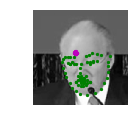

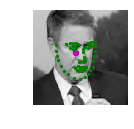

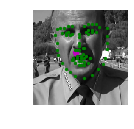

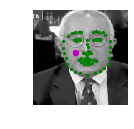

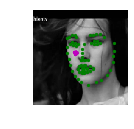

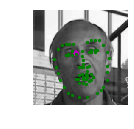

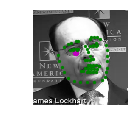

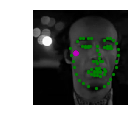

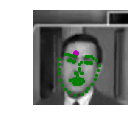

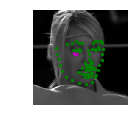

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr= 0.00035, betas=(0.8, 0.999))

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.4555117696523666
Epoch: 1, Batch: 20, Avg. Loss: 0.20455301702022552
Epoch: 1, Batch: 30, Avg. Loss: 0.1911424770951271
Epoch: 1, Batch: 40, Avg. Loss: 0.2129295326769352
Epoch: 1, Batch: 50, Avg. Loss: 0.20100372433662414
Epoch: 1, Batch: 60, Avg. Loss: 0.2218430832028389
Epoch: 1, Batch: 70, Avg. Loss: 0.18227296322584152
Epoch: 1, Batch: 80, Avg. Loss: 0.20888183861970902
Epoch: 1, Batch: 90, Avg. Loss: 0.2691180996596813
Epoch: 1, Batch: 100, Avg. Loss: 0.16875640377402307
Epoch: 1, Batch: 110, Avg. Loss: 0.2030905783176422
Epoch: 1, Batch: 120, Avg. Loss: 0.2410380408167839
Epoch: 1, Batch: 130, Avg. Loss: 0.23380296528339387
Epoch: 1, Batch: 140, Avg. Loss: 0.19825902581214905
Epoch: 1, Batch: 150, Avg. Loss: 0.17682207226753235
Epoch: 1, Batch: 160, Avg. Loss: 0.1939077138900757
Epoch: 1, Batch: 170, Avg. Loss: 0.19905970245599747
Epoch: 1, Batch: 180, Avg. Loss: 0.17231457084417343
Epoch: 1, Batch: 190, Avg. Loss: 0.1451522670686245
Epoch: 1, B

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.1769939474761486
Epoch: 2, Batch: 20, Avg. Loss: 0.16809409335255623
Epoch: 2, Batch: 30, Avg. Loss: 0.22580327689647675
Epoch: 2, Batch: 40, Avg. Loss: 0.20100677236914635
Epoch: 2, Batch: 50, Avg. Loss: 0.20477884784340858
Epoch: 2, Batch: 60, Avg. Loss: 0.17607859671115875
Epoch: 2, Batch: 70, Avg. Loss: 0.15979394987225531
Epoch: 2, Batch: 80, Avg. Loss: 0.1698524348437786
Epoch: 2, Batch: 90, Avg. Loss: 0.22518518567085266
Epoch: 2, Batch: 100, Avg. Loss: 0.172757438570261
Epoch: 2, Batch: 110, Avg. Loss: 0.18648184090852737
Epoch: 2, Batch: 120, Avg. Loss: 0.18922101259231566
Epoch: 2, Batch: 130, Avg. Loss: 0.22187304943799974
Epoch: 2, Batch: 140, Avg. Loss: 0.1626149296760559
Epoch: 2, Batch: 150, Avg. Loss: 0.16553905755281448
Epoch: 2, Batch: 160, Avg. Loss: 0.18602826744318007
Epoch: 2, Batch: 170, Avg. Loss: 0.15524011477828026
Epoch: 2, Batch: 180, Avg. Loss: 0.15716970413923265
Epoch: 2, Batch: 190, Avg. Loss: 0.1683506779372692
Epoch: 2

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.14637827649712562
Epoch: 3, Batch: 20, Avg. Loss: 0.13551078289747237
Epoch: 3, Batch: 30, Avg. Loss: 0.1497434303164482
Epoch: 3, Batch: 40, Avg. Loss: 0.14409109801054001
Epoch: 3, Batch: 50, Avg. Loss: 0.11805829182267188
Epoch: 3, Batch: 60, Avg. Loss: 0.15611406415700912
Epoch: 3, Batch: 70, Avg. Loss: 0.1910648874938488
Epoch: 3, Batch: 80, Avg. Loss: 0.17635596990585328
Epoch: 3, Batch: 90, Avg. Loss: 0.13833243697881697
Epoch: 3, Batch: 100, Avg. Loss: 0.1487142875790596
Epoch: 3, Batch: 110, Avg. Loss: 0.1601279377937317
Epoch: 3, Batch: 120, Avg. Loss: 0.2182322047650814
Epoch: 3, Batch: 130, Avg. Loss: 0.14154278188943864
Epoch: 3, Batch: 140, Avg. Loss: 0.1536344915628433
Epoch: 3, Batch: 150, Avg. Loss: 0.13384388759732246
Epoch: 3, Batch: 160, Avg. Loss: 0.18547203317284583
Epoch: 3, Batch: 170, Avg. Loss: 0.12747715041041374
Epoch: 3, Batch: 180, Avg. Loss: 0.13437573313713075
Epoch: 3, Batch: 190, Avg. Loss: 0.140921488404274
Epoch: 3, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.11738446280360222
Epoch: 4, Batch: 20, Avg. Loss: 0.1382874958217144
Epoch: 4, Batch: 30, Avg. Loss: 0.17036004438996316
Epoch: 4, Batch: 40, Avg. Loss: 0.18771846815943719
Epoch: 4, Batch: 50, Avg. Loss: 0.11703699752688408
Epoch: 4, Batch: 60, Avg. Loss: 0.1440696891397238
Epoch: 4, Batch: 70, Avg. Loss: 0.17032492458820342
Epoch: 4, Batch: 80, Avg. Loss: 0.12292063161730767
Epoch: 4, Batch: 90, Avg. Loss: 0.1324722096323967
Epoch: 4, Batch: 100, Avg. Loss: 0.1259531244635582
Epoch: 4, Batch: 110, Avg. Loss: 0.17336716651916503
Epoch: 4, Batch: 120, Avg. Loss: 0.18503759801387787
Epoch: 4, Batch: 130, Avg. Loss: 0.16782684475183487
Epoch: 4, Batch: 140, Avg. Loss: 0.17017940506339074
Epoch: 4, Batch: 150, Avg. Loss: 0.09812943488359452
Epoch: 4, Batch: 160, Avg. Loss: 0.1540429599583149
Epoch: 4, Batch: 170, Avg. Loss: 0.17686067298054695
Epoch: 4, Batch: 180, Avg. Loss: 0.1028832383453846
Epoch: 4, Batch: 190, Avg. Loss: 0.11383571773767472
Epoch: 4

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.19690849706530572
Epoch: 5, Batch: 20, Avg. Loss: 0.12208406701683998
Epoch: 5, Batch: 30, Avg. Loss: 0.09977388270199299
Epoch: 5, Batch: 40, Avg. Loss: 0.12511304430663586
Epoch: 5, Batch: 50, Avg. Loss: 0.07110743671655655
Epoch: 5, Batch: 60, Avg. Loss: 0.0828679546713829
Epoch: 5, Batch: 70, Avg. Loss: 0.08444738201797009
Epoch: 5, Batch: 80, Avg. Loss: 0.09713465422391891
Epoch: 5, Batch: 90, Avg. Loss: 0.07698102593421936
Epoch: 5, Batch: 100, Avg. Loss: 0.164835886657238
Epoch: 5, Batch: 110, Avg. Loss: 0.09442434683442116
Epoch: 5, Batch: 120, Avg. Loss: 0.09485811442136764
Epoch: 5, Batch: 130, Avg. Loss: 0.16514039859175683
Epoch: 5, Batch: 140, Avg. Loss: 0.10441940762102604
Epoch: 5, Batch: 150, Avg. Loss: 0.0782107062637806
Epoch: 5, Batch: 160, Avg. Loss: 0.07757850997149944
Epoch: 5, Batch: 170, Avg. Loss: 0.07772119753062726
Epoch: 5, Batch: 180, Avg. Loss: 0.08999979570508003
Epoch: 5, Batch: 190, Avg. Loss: 0.07052637711167335
Epoch:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.057813861221075055
Epoch: 6, Batch: 20, Avg. Loss: 0.07023188695311547
Epoch: 6, Batch: 30, Avg. Loss: 0.15491926930844785
Epoch: 6, Batch: 40, Avg. Loss: 0.0669394925236702
Epoch: 6, Batch: 50, Avg. Loss: 0.05077890194952488
Epoch: 6, Batch: 60, Avg. Loss: 0.05625233240425587
Epoch: 6, Batch: 70, Avg. Loss: 0.07762265428900719
Epoch: 6, Batch: 80, Avg. Loss: 0.06035775206983089
Epoch: 6, Batch: 90, Avg. Loss: 0.06304808426648378
Epoch: 6, Batch: 100, Avg. Loss: 0.07829928938299417
Epoch: 6, Batch: 110, Avg. Loss: 0.07328031919896602
Epoch: 6, Batch: 120, Avg. Loss: 0.1839149847626686
Epoch: 6, Batch: 130, Avg. Loss: 0.10552454367280006
Epoch: 6, Batch: 140, Avg. Loss: 0.056995895504951474
Epoch: 6, Batch: 150, Avg. Loss: 0.07988704107701779
Epoch: 6, Batch: 160, Avg. Loss: 0.05190284438431263
Epoch: 6, Batch: 170, Avg. Loss: 0.050511830113828184
Epoch: 6, Batch: 180, Avg. Loss: 0.08334807567298412
Epoch: 6, Batch: 190, Avg. Loss: 0.14296189956367017
E

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.04425049237906933
Epoch: 7, Batch: 20, Avg. Loss: 0.04566462095826864
Epoch: 7, Batch: 30, Avg. Loss: 0.04460214469581843
Epoch: 7, Batch: 40, Avg. Loss: 0.05447829961776733
Epoch: 7, Batch: 50, Avg. Loss: 0.05584604907780886
Epoch: 7, Batch: 60, Avg. Loss: 0.06595315448939801
Epoch: 7, Batch: 70, Avg. Loss: 0.06745215095579624
Epoch: 7, Batch: 80, Avg. Loss: 0.07379758190363646
Epoch: 7, Batch: 90, Avg. Loss: 0.05810890682041645
Epoch: 7, Batch: 100, Avg. Loss: 0.052440996281802654
Epoch: 7, Batch: 110, Avg. Loss: 0.03878220152109861
Epoch: 7, Batch: 120, Avg. Loss: 0.04634626396000385
Epoch: 7, Batch: 130, Avg. Loss: 0.04862495884299278
Epoch: 7, Batch: 140, Avg. Loss: 0.07163333371281624
Epoch: 7, Batch: 150, Avg. Loss: 0.08203976973891258
Epoch: 7, Batch: 160, Avg. Loss: 0.10787005051970482
Epoch: 7, Batch: 170, Avg. Loss: 0.05109188258647919
Epoch: 7, Batch: 180, Avg. Loss: 0.04193931575864553
Epoch: 7, Batch: 190, Avg. Loss: 0.15790436491370202
E

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.048155336454510686
Epoch: 8, Batch: 20, Avg. Loss: 0.041059473901987074
Epoch: 8, Batch: 30, Avg. Loss: 0.04780473634600639
Epoch: 8, Batch: 40, Avg. Loss: 0.04803130533546209
Epoch: 8, Batch: 50, Avg. Loss: 0.040542418137192726
Epoch: 8, Batch: 60, Avg. Loss: 0.04150754753500223
Epoch: 8, Batch: 70, Avg. Loss: 0.03204975239932537
Epoch: 8, Batch: 80, Avg. Loss: 0.03571781404316425
Epoch: 8, Batch: 90, Avg. Loss: 0.05784222278743982
Epoch: 8, Batch: 100, Avg. Loss: 0.03781053405255079
Epoch: 8, Batch: 110, Avg. Loss: 0.10130362287163734
Epoch: 8, Batch: 120, Avg. Loss: 0.0559680262580514
Epoch: 8, Batch: 130, Avg. Loss: 0.14448053743690253
Epoch: 8, Batch: 140, Avg. Loss: 0.05288276840001345
Epoch: 8, Batch: 150, Avg. Loss: 0.095233797095716
Epoch: 8, Batch: 160, Avg. Loss: 0.08873137980699539
Epoch: 8, Batch: 170, Avg. Loss: 0.0415448859333992
Epoch: 8, Batch: 180, Avg. Loss: 0.03953275363892317
Epoch: 8, Batch: 190, Avg. Loss: 0.04052493087947369
Epo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.04329895172268152
Epoch: 9, Batch: 20, Avg. Loss: 0.04651804398745298
Epoch: 9, Batch: 30, Avg. Loss: 0.09336044806987047
Epoch: 9, Batch: 40, Avg. Loss: 0.03621298773214221
Epoch: 9, Batch: 50, Avg. Loss: 0.03839194718748331
Epoch: 9, Batch: 60, Avg. Loss: 0.03573391996324062
Epoch: 9, Batch: 70, Avg. Loss: 0.03138942345976829
Epoch: 9, Batch: 80, Avg. Loss: 0.03488742709159851
Epoch: 9, Batch: 90, Avg. Loss: 0.03342162352055311
Epoch: 9, Batch: 100, Avg. Loss: 0.05526166055351496
Epoch: 9, Batch: 110, Avg. Loss: 0.0371814452111721
Epoch: 9, Batch: 120, Avg. Loss: 0.03856463469564915
Epoch: 9, Batch: 130, Avg. Loss: 0.028027365542948247
Epoch: 9, Batch: 140, Avg. Loss: 0.04715623613446951
Epoch: 9, Batch: 150, Avg. Loss: 0.11144163161516189
Epoch: 9, Batch: 160, Avg. Loss: 0.08193104956299066
Epoch: 9, Batch: 170, Avg. Loss: 0.07231163680553436
Epoch: 9, Batch: 180, Avg. Loss: 0.21940368562936782
Epoch: 9, Batch: 190, Avg. Loss: 0.03273898214101791
Ep

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.033979423344135284
Epoch: 10, Batch: 20, Avg. Loss: 0.06221360992640257
Epoch: 10, Batch: 30, Avg. Loss: 0.03701868485659361
Epoch: 10, Batch: 40, Avg. Loss: 0.04929389040917158
Epoch: 10, Batch: 50, Avg. Loss: 0.037955771572887896
Epoch: 10, Batch: 60, Avg. Loss: 0.03831181805580854
Epoch: 10, Batch: 70, Avg. Loss: 0.08082747720181942
Epoch: 10, Batch: 80, Avg. Loss: 0.05543626826256513
Epoch: 10, Batch: 90, Avg. Loss: 0.03807003162801266
Epoch: 10, Batch: 100, Avg. Loss: 0.04358804877847433
Epoch: 10, Batch: 110, Avg. Loss: 0.037088217213749886
Epoch: 10, Batch: 120, Avg. Loss: 0.04268985912203789
Epoch: 10, Batch: 130, Avg. Loss: 0.05436706356704235
Epoch: 10, Batch: 140, Avg. Loss: 0.038823785819113256
Epoch: 10, Batch: 150, Avg. Loss: 0.04656973965466023
Epoch: 10, Batch: 160, Avg. Loss: 0.12406761534512042
Epoch: 10, Batch: 170, Avg. Loss: 0.05264162700623274
Epoch: 10, Batch: 180, Avg. Loss: 0.03150341305881739
Epoch: 10, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.03946620225906372
Epoch: 11, Batch: 20, Avg. Loss: 0.029717928916215896
Epoch: 11, Batch: 30, Avg. Loss: 0.039250917918980124
Epoch: 11, Batch: 40, Avg. Loss: 0.0316960072144866
Epoch: 11, Batch: 50, Avg. Loss: 0.03553255219012499
Epoch: 11, Batch: 60, Avg. Loss: 0.21485082302242517
Epoch: 11, Batch: 70, Avg. Loss: 0.03200502656400204
Epoch: 11, Batch: 80, Avg. Loss: 0.03348298976197839
Epoch: 11, Batch: 90, Avg. Loss: 0.033632782846689226
Epoch: 11, Batch: 100, Avg. Loss: 0.043471348099410535
Epoch: 11, Batch: 110, Avg. Loss: 0.0300468809902668
Epoch: 11, Batch: 120, Avg. Loss: 0.03728286176919937
Epoch: 11, Batch: 130, Avg. Loss: 0.05281682834029198
Epoch: 11, Batch: 140, Avg. Loss: 0.06424611397087573
Epoch: 11, Batch: 150, Avg. Loss: 0.08303151316940785
Epoch: 11, Batch: 160, Avg. Loss: 0.038778112083673474
Epoch: 11, Batch: 170, Avg. Loss: 0.03753060568124056
Epoch: 11, Batch: 180, Avg. Loss: 0.03215571492910385
Epoch: 11, Batch: 190, Avg. Loss: 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.030084196664392947
Epoch: 12, Batch: 20, Avg. Loss: 0.026575901545584202
Epoch: 12, Batch: 30, Avg. Loss: 0.02812018059194088
Epoch: 12, Batch: 40, Avg. Loss: 0.03245800547301769
Epoch: 12, Batch: 50, Avg. Loss: 0.030593260191380978
Epoch: 12, Batch: 60, Avg. Loss: 0.03397182952612639
Epoch: 12, Batch: 70, Avg. Loss: 0.038052068836987016
Epoch: 12, Batch: 80, Avg. Loss: 0.03202605322003364
Epoch: 12, Batch: 90, Avg. Loss: 0.05666082724928856
Epoch: 12, Batch: 100, Avg. Loss: 0.030232788436114787
Epoch: 12, Batch: 110, Avg. Loss: 0.097259964607656
Epoch: 12, Batch: 120, Avg. Loss: 0.035892119910567996
Epoch: 12, Batch: 130, Avg. Loss: 0.03146960884332657
Epoch: 12, Batch: 140, Avg. Loss: 0.02722593620419502
Epoch: 12, Batch: 150, Avg. Loss: 0.036795221455395224
Epoch: 12, Batch: 160, Avg. Loss: 0.03278567530214786
Epoch: 12, Batch: 170, Avg. Loss: 0.03229404017329216
Epoch: 12, Batch: 180, Avg. Loss: 0.03294095490127802
Epoch: 12, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.03296777382493019
Epoch: 13, Batch: 20, Avg. Loss: 0.1752743236720562
Epoch: 13, Batch: 30, Avg. Loss: 0.04065330578014255
Epoch: 13, Batch: 40, Avg. Loss: 0.08093274496495724
Epoch: 13, Batch: 50, Avg. Loss: 0.027811709232628344
Epoch: 13, Batch: 60, Avg. Loss: 0.05630412083119154
Epoch: 13, Batch: 70, Avg. Loss: 0.050511193834245204
Epoch: 13, Batch: 80, Avg. Loss: 0.028123950958251952
Epoch: 13, Batch: 90, Avg. Loss: 0.02847073171287775
Epoch: 13, Batch: 100, Avg. Loss: 0.028423196356743573
Epoch: 13, Batch: 110, Avg. Loss: 0.027072505094110966
Epoch: 13, Batch: 120, Avg. Loss: 0.052402643486857414
Epoch: 13, Batch: 130, Avg. Loss: 0.03349220100790262
Epoch: 13, Batch: 140, Avg. Loss: 0.0305155286565423
Epoch: 13, Batch: 150, Avg. Loss: 0.21312250029295682
Epoch: 13, Batch: 160, Avg. Loss: 0.0585960416123271
Epoch: 13, Batch: 170, Avg. Loss: 0.05682316105812788
Epoch: 13, Batch: 180, Avg. Loss: 0.028903067205101253
Epoch: 13, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.027513963542878626
Epoch: 14, Batch: 20, Avg. Loss: 0.02517247386276722
Epoch: 14, Batch: 30, Avg. Loss: 0.030173185281455517
Epoch: 14, Batch: 40, Avg. Loss: 0.050260547734797004
Epoch: 14, Batch: 50, Avg. Loss: 0.030963260866701602
Epoch: 14, Batch: 60, Avg. Loss: 0.038772781006991865
Epoch: 14, Batch: 70, Avg. Loss: 0.09422437101602554
Epoch: 14, Batch: 80, Avg. Loss: 0.03589815441519022
Epoch: 14, Batch: 90, Avg. Loss: 0.03896886315196753
Epoch: 14, Batch: 100, Avg. Loss: 0.04449778012931347
Epoch: 14, Batch: 110, Avg. Loss: 0.030073955841362476
Epoch: 14, Batch: 120, Avg. Loss: 0.031976344808936116
Epoch: 14, Batch: 130, Avg. Loss: 0.029908221587538718
Epoch: 14, Batch: 140, Avg. Loss: 0.028955018892884255
Epoch: 14, Batch: 150, Avg. Loss: 0.039372720383107664
Epoch: 14, Batch: 160, Avg. Loss: 0.028994864970445632
Epoch: 14, Batch: 170, Avg. Loss: 0.026627270691096782
Epoch: 14, Batch: 180, Avg. Loss: 0.02666219472885132
Epoch: 14, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.021220541931688784
Epoch: 15, Batch: 20, Avg. Loss: 0.035316833574324843
Epoch: 15, Batch: 30, Avg. Loss: 0.025871103815734386
Epoch: 15, Batch: 40, Avg. Loss: 0.03070754501968622
Epoch: 15, Batch: 50, Avg. Loss: 0.03695565015077591
Epoch: 15, Batch: 60, Avg. Loss: 0.025485272333025933
Epoch: 15, Batch: 70, Avg. Loss: 0.023250012565404175
Epoch: 15, Batch: 80, Avg. Loss: 0.1292382709681988
Epoch: 15, Batch: 90, Avg. Loss: 0.05624239444732666
Epoch: 15, Batch: 100, Avg. Loss: 0.038366646692156794
Epoch: 15, Batch: 110, Avg. Loss: 0.024935755506157876
Epoch: 15, Batch: 120, Avg. Loss: 0.027684517949819566
Epoch: 15, Batch: 130, Avg. Loss: 0.027361890487372875
Epoch: 15, Batch: 140, Avg. Loss: 0.02300482615828514
Epoch: 15, Batch: 150, Avg. Loss: 0.033442719373852015
Epoch: 15, Batch: 160, Avg. Loss: 0.0937194736674428
Epoch: 15, Batch: 170, Avg. Loss: 0.0729919869452715
Epoch: 15, Batch: 180, Avg. Loss: 0.03660330660641194
Epoch: 15, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.034199785068631174
Epoch: 16, Batch: 20, Avg. Loss: 0.030130036920309067
Epoch: 16, Batch: 30, Avg. Loss: 0.06963866213336586
Epoch: 16, Batch: 40, Avg. Loss: 0.043826318345963955
Epoch: 16, Batch: 50, Avg. Loss: 0.030960554257035255
Epoch: 16, Batch: 60, Avg. Loss: 0.02983651766553521
Epoch: 16, Batch: 70, Avg. Loss: 0.0325023002922535
Epoch: 16, Batch: 80, Avg. Loss: 0.027722661942243577
Epoch: 16, Batch: 90, Avg. Loss: 0.03681859504431486
Epoch: 16, Batch: 100, Avg. Loss: 0.2197621618397534
Epoch: 16, Batch: 110, Avg. Loss: 0.02805856605991721
Epoch: 16, Batch: 120, Avg. Loss: 0.02643819246441126
Epoch: 16, Batch: 130, Avg. Loss: 0.024542361311614514
Epoch: 16, Batch: 140, Avg. Loss: 0.022681013122200964
Epoch: 16, Batch: 150, Avg. Loss: 0.024262012913823128
Epoch: 16, Batch: 160, Avg. Loss: 0.027457631006836892
Epoch: 16, Batch: 170, Avg. Loss: 0.022462243773043157
Epoch: 16, Batch: 180, Avg. Loss: 0.02830333951860666
Epoch: 16, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.022355921659618617
Epoch: 17, Batch: 20, Avg. Loss: 0.04281878042966127
Epoch: 17, Batch: 30, Avg. Loss: 0.02359912320971489
Epoch: 17, Batch: 40, Avg. Loss: 0.022294162772595882
Epoch: 17, Batch: 50, Avg. Loss: 0.030164689291268587
Epoch: 17, Batch: 60, Avg. Loss: 0.027152404468506575
Epoch: 17, Batch: 70, Avg. Loss: 0.024200862646102904
Epoch: 17, Batch: 80, Avg. Loss: 0.02365843765437603
Epoch: 17, Batch: 90, Avg. Loss: 0.02196191232651472
Epoch: 17, Batch: 100, Avg. Loss: 0.022270149365067483
Epoch: 17, Batch: 110, Avg. Loss: 0.023213931266218422
Epoch: 17, Batch: 120, Avg. Loss: 0.029854802042245866
Epoch: 17, Batch: 130, Avg. Loss: 0.03026933167129755
Epoch: 17, Batch: 140, Avg. Loss: 0.02860185271129012
Epoch: 17, Batch: 150, Avg. Loss: 0.019857198745012284
Epoch: 17, Batch: 160, Avg. Loss: 0.023315643332898615
Epoch: 17, Batch: 170, Avg. Loss: 0.08201631447300314
Epoch: 17, Batch: 180, Avg. Loss: 0.023890006355941296
Epoch: 17, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.04261935781687498
Epoch: 18, Batch: 20, Avg. Loss: 0.03061071652919054
Epoch: 18, Batch: 30, Avg. Loss: 0.040229491889476776
Epoch: 18, Batch: 40, Avg. Loss: 0.024414676055312157
Epoch: 18, Batch: 50, Avg. Loss: 0.025556541047990322
Epoch: 18, Batch: 60, Avg. Loss: 0.025935032404959202
Epoch: 18, Batch: 70, Avg. Loss: 0.02477931808680296
Epoch: 18, Batch: 80, Avg. Loss: 0.023819907754659652
Epoch: 18, Batch: 90, Avg. Loss: 0.057474101148545745
Epoch: 18, Batch: 100, Avg. Loss: 0.036427016742527484
Epoch: 18, Batch: 110, Avg. Loss: 0.03005512896925211
Epoch: 18, Batch: 120, Avg. Loss: 0.028039880841970444
Epoch: 18, Batch: 130, Avg. Loss: 0.07061345744878053
Epoch: 18, Batch: 140, Avg. Loss: 0.08310013897716999
Epoch: 18, Batch: 150, Avg. Loss: 0.10287586711347103
Epoch: 18, Batch: 160, Avg. Loss: 0.10650841444730759
Epoch: 18, Batch: 170, Avg. Loss: 0.03586444985121488
Epoch: 18, Batch: 180, Avg. Loss: 0.032114277593791485
Epoch: 18, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.05146875325590372
Epoch: 19, Batch: 20, Avg. Loss: 0.035919707454741004
Epoch: 19, Batch: 30, Avg. Loss: 0.027667607739567758
Epoch: 19, Batch: 40, Avg. Loss: 0.03314516991376877
Epoch: 19, Batch: 50, Avg. Loss: 0.0317897105589509
Epoch: 19, Batch: 60, Avg. Loss: 0.02353319227695465
Epoch: 19, Batch: 70, Avg. Loss: 0.029056341759860514
Epoch: 19, Batch: 80, Avg. Loss: 0.021678001433610917
Epoch: 19, Batch: 90, Avg. Loss: 0.02944003539159894
Epoch: 19, Batch: 100, Avg. Loss: 0.027689039800316097
Epoch: 19, Batch: 110, Avg. Loss: 0.02333185523748398
Epoch: 19, Batch: 120, Avg. Loss: 0.028483594208955763
Epoch: 19, Batch: 130, Avg. Loss: 0.022899734042584895
Epoch: 19, Batch: 140, Avg. Loss: 0.027737632766366004
Epoch: 19, Batch: 150, Avg. Loss: 0.0262572237290442
Epoch: 19, Batch: 160, Avg. Loss: 0.0232490886002779
Epoch: 19, Batch: 170, Avg. Loss: 0.02552740667015314
Epoch: 19, Batch: 180, Avg. Loss: 0.025523627549409865
Epoch: 19, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.02871228866279125
Epoch: 20, Batch: 20, Avg. Loss: 0.028976506926119326
Epoch: 20, Batch: 30, Avg. Loss: 0.024951277114450932
Epoch: 20, Batch: 40, Avg. Loss: 0.02096865903586149
Epoch: 20, Batch: 50, Avg. Loss: 0.020125385466963054
Epoch: 20, Batch: 60, Avg. Loss: 0.023603090085089207
Epoch: 20, Batch: 70, Avg. Loss: 0.02601064182817936
Epoch: 20, Batch: 80, Avg. Loss: 0.025350293889641762
Epoch: 20, Batch: 90, Avg. Loss: 0.030922050587832928
Epoch: 20, Batch: 100, Avg. Loss: 0.020359713397920132
Epoch: 20, Batch: 110, Avg. Loss: 0.024430787935853005
Epoch: 20, Batch: 120, Avg. Loss: 0.03323175394907594
Epoch: 20, Batch: 130, Avg. Loss: 0.022665347438305616
Epoch: 20, Batch: 140, Avg. Loss: 0.021613131556659938
Epoch: 20, Batch: 150, Avg. Loss: 0.024967319797724485
Epoch: 20, Batch: 160, Avg. Loss: 0.0395344696007669
Epoch: 20, Batch: 170, Avg. Loss: 0.025796251930296422
Epoch: 20, Batch: 180, Avg. Loss: 0.030411610193550587
Epoch: 20, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.05172126032412052
Epoch: 21, Batch: 20, Avg. Loss: 0.03228018628433347
Epoch: 21, Batch: 30, Avg. Loss: 0.02509433515369892
Epoch: 21, Batch: 40, Avg. Loss: 0.02764848116785288
Epoch: 21, Batch: 50, Avg. Loss: 0.053676589764654635
Epoch: 21, Batch: 60, Avg. Loss: 0.11260282630100846
Epoch: 21, Batch: 70, Avg. Loss: 0.06889545302838088
Epoch: 21, Batch: 80, Avg. Loss: 0.027012977935373782
Epoch: 21, Batch: 90, Avg. Loss: 0.027525752782821655
Epoch: 21, Batch: 100, Avg. Loss: 0.04940567146986723
Epoch: 21, Batch: 110, Avg. Loss: 0.04745309595018625
Epoch: 21, Batch: 120, Avg. Loss: 0.03626829404383898
Epoch: 21, Batch: 130, Avg. Loss: 0.03628094512969256
Epoch: 21, Batch: 140, Avg. Loss: 0.03168765362352133
Epoch: 21, Batch: 150, Avg. Loss: 0.022423248365521432
Epoch: 21, Batch: 160, Avg. Loss: 0.10110286511480808
Epoch: 21, Batch: 170, Avg. Loss: 0.04117974052205682
Epoch: 21, Batch: 180, Avg. Loss: 0.03817957965657115
Epoch: 21, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.02416424248367548
Epoch: 22, Batch: 20, Avg. Loss: 0.023548935912549494
Epoch: 22, Batch: 30, Avg. Loss: 0.02218330670148134
Epoch: 22, Batch: 40, Avg. Loss: 0.021670596022158862
Epoch: 22, Batch: 50, Avg. Loss: 0.025086033903062344
Epoch: 22, Batch: 60, Avg. Loss: 0.027756883390247823
Epoch: 22, Batch: 70, Avg. Loss: 0.018766959197819233
Epoch: 22, Batch: 80, Avg. Loss: 0.11397991525009274
Epoch: 22, Batch: 90, Avg. Loss: 0.08151510283350945
Epoch: 22, Batch: 100, Avg. Loss: 0.028990183770656586
Epoch: 22, Batch: 110, Avg. Loss: 0.05923610329627991
Epoch: 22, Batch: 120, Avg. Loss: 0.0273190813139081
Epoch: 22, Batch: 130, Avg. Loss: 0.03057241775095463
Epoch: 22, Batch: 140, Avg. Loss: 0.026120510697364808
Epoch: 22, Batch: 150, Avg. Loss: 0.04832101874053478
Epoch: 22, Batch: 160, Avg. Loss: 0.03487218609079719
Epoch: 22, Batch: 170, Avg. Loss: 0.03292070534080267
Epoch: 22, Batch: 180, Avg. Loss: 0.0808939604088664
Epoch: 22, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.03837276417762041
Epoch: 23, Batch: 20, Avg. Loss: 0.04550146535038948
Epoch: 23, Batch: 30, Avg. Loss: 0.022826685942709445
Epoch: 23, Batch: 40, Avg. Loss: 0.0342928497120738
Epoch: 23, Batch: 50, Avg. Loss: 0.02251384798437357
Epoch: 23, Batch: 60, Avg. Loss: 0.021340032014995812
Epoch: 23, Batch: 70, Avg. Loss: 0.026016406156122683
Epoch: 23, Batch: 80, Avg. Loss: 0.02650738526135683
Epoch: 23, Batch: 90, Avg. Loss: 0.025051751732826234
Epoch: 23, Batch: 100, Avg. Loss: 0.03651115885004401
Epoch: 23, Batch: 110, Avg. Loss: 0.021312166843563317
Epoch: 23, Batch: 120, Avg. Loss: 0.0198831582441926
Epoch: 23, Batch: 130, Avg. Loss: 0.037996616959571836
Epoch: 23, Batch: 140, Avg. Loss: 0.03014571378007531
Epoch: 23, Batch: 150, Avg. Loss: 0.020052216574549676
Epoch: 23, Batch: 160, Avg. Loss: 0.026239057444036006
Epoch: 23, Batch: 170, Avg. Loss: 0.020610719826072453
Epoch: 23, Batch: 180, Avg. Loss: 0.021459908317774536
Epoch: 23, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.023794923909008503
Epoch: 24, Batch: 20, Avg. Loss: 0.023120265267789365
Epoch: 24, Batch: 30, Avg. Loss: 0.026166163757443427
Epoch: 24, Batch: 40, Avg. Loss: 0.022708786465227605
Epoch: 24, Batch: 50, Avg. Loss: 0.15081500113010407
Epoch: 24, Batch: 60, Avg. Loss: 0.08185759317129851
Epoch: 24, Batch: 70, Avg. Loss: 0.030363824777305128
Epoch: 24, Batch: 80, Avg. Loss: 0.05505706686526537
Epoch: 24, Batch: 90, Avg. Loss: 0.12649155054241418
Epoch: 24, Batch: 100, Avg. Loss: 0.13123688604682684
Epoch: 24, Batch: 110, Avg. Loss: 0.06337139029055834
Epoch: 24, Batch: 120, Avg. Loss: 0.020904389210045338
Epoch: 24, Batch: 130, Avg. Loss: 0.02493107635527849
Epoch: 24, Batch: 140, Avg. Loss: 0.02417263574898243
Epoch: 24, Batch: 150, Avg. Loss: 0.036543922126293184
Epoch: 24, Batch: 160, Avg. Loss: 0.028022526856511833
Epoch: 24, Batch: 170, Avg. Loss: 0.060310174617916344
Epoch: 24, Batch: 180, Avg. Loss: 0.024166515190154315
Epoch: 24, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.023818278685212135
Epoch: 25, Batch: 20, Avg. Loss: 0.022388988733291627
Epoch: 25, Batch: 30, Avg. Loss: 0.03006769102066755
Epoch: 25, Batch: 40, Avg. Loss: 0.04038132466375828
Epoch: 25, Batch: 50, Avg. Loss: 0.02691783681511879
Epoch: 25, Batch: 60, Avg. Loss: 0.046807458810508254
Epoch: 25, Batch: 70, Avg. Loss: 0.021724974736571312
Epoch: 25, Batch: 80, Avg. Loss: 0.02836516806855798
Epoch: 25, Batch: 90, Avg. Loss: 0.025316887907683848
Epoch: 25, Batch: 100, Avg. Loss: 0.02269696807488799
Epoch: 25, Batch: 110, Avg. Loss: 0.03151999209076166
Epoch: 25, Batch: 120, Avg. Loss: 0.021086972765624525
Epoch: 25, Batch: 130, Avg. Loss: 0.028332906775176525
Epoch: 25, Batch: 140, Avg. Loss: 0.05743702556937933
Epoch: 25, Batch: 150, Avg. Loss: 0.07641559932380915
Epoch: 25, Batch: 160, Avg. Loss: 0.03262677136808634
Epoch: 25, Batch: 170, Avg. Loss: 0.023663024231791497
Epoch: 25, Batch: 180, Avg. Loss: 0.04350547986105084
Epoch: 25, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.15404934976249934
Epoch: 26, Batch: 20, Avg. Loss: 0.026746041141450405
Epoch: 26, Batch: 30, Avg. Loss: 0.019754953123629092
Epoch: 26, Batch: 40, Avg. Loss: 0.02265165625140071
Epoch: 26, Batch: 50, Avg. Loss: 0.020024140086025
Epoch: 26, Batch: 60, Avg. Loss: 0.022193858213722707
Epoch: 26, Batch: 70, Avg. Loss: 0.021155648212879897
Epoch: 26, Batch: 80, Avg. Loss: 0.021594001073390247
Epoch: 26, Batch: 90, Avg. Loss: 0.023216151259839536
Epoch: 26, Batch: 100, Avg. Loss: 0.02333678975701332
Epoch: 26, Batch: 110, Avg. Loss: 0.020009199716150762
Epoch: 26, Batch: 120, Avg. Loss: 0.023364836908876897
Epoch: 26, Batch: 130, Avg. Loss: 0.025788588635623454
Epoch: 26, Batch: 140, Avg. Loss: 0.021963387727737427
Epoch: 26, Batch: 150, Avg. Loss: 0.0198260935023427
Epoch: 26, Batch: 160, Avg. Loss: 0.02362569682300091
Epoch: 26, Batch: 170, Avg. Loss: 0.024258569162338973
Epoch: 26, Batch: 180, Avg. Loss: 0.02208731006830931
Epoch: 26, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.0212590167298913
Epoch: 27, Batch: 20, Avg. Loss: 0.027382721100002526
Epoch: 27, Batch: 30, Avg. Loss: 0.017333810683339834
Epoch: 27, Batch: 40, Avg. Loss: 0.026345957722514867
Epoch: 27, Batch: 50, Avg. Loss: 0.039486156590282914
Epoch: 27, Batch: 60, Avg. Loss: 0.04858117857947945
Epoch: 27, Batch: 70, Avg. Loss: 0.018995219096541404
Epoch: 27, Batch: 80, Avg. Loss: 0.042776485346257685
Epoch: 27, Batch: 90, Avg. Loss: 0.021949598379433156
Epoch: 27, Batch: 100, Avg. Loss: 0.022352248430252075
Epoch: 27, Batch: 110, Avg. Loss: 0.0367389352992177
Epoch: 27, Batch: 120, Avg. Loss: 0.023170132469385863
Epoch: 27, Batch: 130, Avg. Loss: 0.02194294799119234
Epoch: 27, Batch: 140, Avg. Loss: 0.019834384229034184
Epoch: 27, Batch: 150, Avg. Loss: 0.023280811589211227
Epoch: 27, Batch: 160, Avg. Loss: 0.020867957547307015
Epoch: 27, Batch: 170, Avg. Loss: 0.018872226215898992
Epoch: 27, Batch: 180, Avg. Loss: 0.01905501205474138
Epoch: 27, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.023274812288582324
Epoch: 28, Batch: 20, Avg. Loss: 0.061193259060382844
Epoch: 28, Batch: 30, Avg. Loss: 0.09356917720288038
Epoch: 28, Batch: 40, Avg. Loss: 0.022553442884236573
Epoch: 28, Batch: 50, Avg. Loss: 0.022301561664789915
Epoch: 28, Batch: 60, Avg. Loss: 0.022446733340620993
Epoch: 28, Batch: 70, Avg. Loss: 0.026210851967334747
Epoch: 28, Batch: 80, Avg. Loss: 0.03292999779805541
Epoch: 28, Batch: 90, Avg. Loss: 0.023290217481553556
Epoch: 28, Batch: 100, Avg. Loss: 0.020934958942234516
Epoch: 28, Batch: 110, Avg. Loss: 0.032015534676611425
Epoch: 28, Batch: 120, Avg. Loss: 0.025760242715477943
Epoch: 28, Batch: 130, Avg. Loss: 0.025677382480353117
Epoch: 28, Batch: 140, Avg. Loss: 0.021197614260017872
Epoch: 28, Batch: 150, Avg. Loss: 0.022221196629106998
Epoch: 28, Batch: 160, Avg. Loss: 0.02373320357874036
Epoch: 28, Batch: 170, Avg. Loss: 0.12235311269760132
Epoch: 28, Batch: 180, Avg. Loss: 0.03472804203629494
Epoch: 28, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.028934656362980603
Epoch: 29, Batch: 20, Avg. Loss: 0.09849797710776328
Epoch: 29, Batch: 30, Avg. Loss: 0.025883883610367774
Epoch: 29, Batch: 40, Avg. Loss: 0.02442513229325414
Epoch: 29, Batch: 50, Avg. Loss: 0.024232211895287036
Epoch: 29, Batch: 60, Avg. Loss: 0.025492923427373172
Epoch: 29, Batch: 70, Avg. Loss: 0.025521994940936564
Epoch: 29, Batch: 80, Avg. Loss: 0.032102945167571305
Epoch: 29, Batch: 90, Avg. Loss: 0.02031916743144393
Epoch: 29, Batch: 100, Avg. Loss: 0.019562456011772155
Epoch: 29, Batch: 110, Avg. Loss: 0.021451608277857304
Epoch: 29, Batch: 120, Avg. Loss: 0.02324596615508199
Epoch: 29, Batch: 130, Avg. Loss: 0.020435368176549673
Epoch: 29, Batch: 140, Avg. Loss: 0.020813980139791965
Epoch: 29, Batch: 150, Avg. Loss: 0.030219823028892277
Epoch: 29, Batch: 160, Avg. Loss: 0.017739542294293642
Epoch: 29, Batch: 170, Avg. Loss: 0.020817933790385722
Epoch: 29, Batch: 180, Avg. Loss: 0.11252248175442219
Epoch: 29, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.01746406313031912
Epoch: 30, Batch: 20, Avg. Loss: 0.0778464381583035
Epoch: 30, Batch: 30, Avg. Loss: 0.018881256226450205
Epoch: 30, Batch: 40, Avg. Loss: 0.0214286963455379
Epoch: 30, Batch: 50, Avg. Loss: 0.02862346712499857
Epoch: 30, Batch: 60, Avg. Loss: 0.020752887707203627
Epoch: 30, Batch: 70, Avg. Loss: 0.02142951814457774
Epoch: 30, Batch: 80, Avg. Loss: 0.0214117843657732
Epoch: 30, Batch: 90, Avg. Loss: 0.018397162575274704
Epoch: 30, Batch: 100, Avg. Loss: 0.028096459154039622
Epoch: 30, Batch: 110, Avg. Loss: 0.018760131672024727
Epoch: 30, Batch: 120, Avg. Loss: 0.021881158463656902
Epoch: 30, Batch: 130, Avg. Loss: 0.020999081991612913
Epoch: 30, Batch: 140, Avg. Loss: 0.024030703864991666
Epoch: 30, Batch: 150, Avg. Loss: 0.033700276538729666
Epoch: 30, Batch: 160, Avg. Loss: 0.025466037075966598
Epoch: 30, Batch: 170, Avg. Loss: 0.022773223742842675
Epoch: 30, Batch: 180, Avg. Loss: 0.023176324646919967
Epoch: 30, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.024531730357557534
Epoch: 31, Batch: 20, Avg. Loss: 0.023361727874726058
Epoch: 31, Batch: 30, Avg. Loss: 0.02409408651292324
Epoch: 31, Batch: 40, Avg. Loss: 0.04354321509599686
Epoch: 31, Batch: 50, Avg. Loss: 0.032525623217225075
Epoch: 31, Batch: 60, Avg. Loss: 0.020261739660054446
Epoch: 31, Batch: 70, Avg. Loss: 0.05817938763648271
Epoch: 31, Batch: 80, Avg. Loss: 0.04779597884044051
Epoch: 31, Batch: 90, Avg. Loss: 0.021045692451298236
Epoch: 31, Batch: 100, Avg. Loss: 0.021532166004180908
Epoch: 31, Batch: 110, Avg. Loss: 0.04979952415451407
Epoch: 31, Batch: 120, Avg. Loss: 0.031549060344696046
Epoch: 31, Batch: 130, Avg. Loss: 0.023068753816187382
Epoch: 31, Batch: 140, Avg. Loss: 0.02137088617309928
Epoch: 31, Batch: 150, Avg. Loss: 0.02582274116575718
Epoch: 31, Batch: 160, Avg. Loss: 0.0208842852152884
Epoch: 31, Batch: 170, Avg. Loss: 0.028231027908623217
Epoch: 31, Batch: 180, Avg. Loss: 0.020086669269949196
Epoch: 31, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.030611911322921515
Epoch: 32, Batch: 20, Avg. Loss: 0.02493600994348526
Epoch: 32, Batch: 30, Avg. Loss: 0.02190077882260084
Epoch: 32, Batch: 40, Avg. Loss: 0.01880680676549673
Epoch: 32, Batch: 50, Avg. Loss: 0.03296388108283281
Epoch: 32, Batch: 60, Avg. Loss: 0.020200200099498033
Epoch: 32, Batch: 70, Avg. Loss: 0.028284834511578084
Epoch: 32, Batch: 80, Avg. Loss: 0.021791147254407405
Epoch: 32, Batch: 90, Avg. Loss: 0.01904509300366044
Epoch: 32, Batch: 100, Avg. Loss: 0.06956872250884771
Epoch: 32, Batch: 110, Avg. Loss: 0.026112650334835053
Epoch: 32, Batch: 120, Avg. Loss: 0.03760492205619812
Epoch: 32, Batch: 130, Avg. Loss: 0.022599908895790576
Epoch: 32, Batch: 140, Avg. Loss: 0.018133619334548712
Epoch: 32, Batch: 150, Avg. Loss: 0.0245660494081676
Epoch: 32, Batch: 160, Avg. Loss: 0.031173028238117694
Epoch: 32, Batch: 170, Avg. Loss: 0.02093065157532692
Epoch: 32, Batch: 180, Avg. Loss: 0.019353974051773547
Epoch: 32, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.041898753680288794
Epoch: 33, Batch: 20, Avg. Loss: 0.0350597869604826
Epoch: 33, Batch: 30, Avg. Loss: 0.02940931050106883
Epoch: 33, Batch: 40, Avg. Loss: 0.024104006495326756
Epoch: 33, Batch: 50, Avg. Loss: 0.03424101863056421
Epoch: 33, Batch: 60, Avg. Loss: 0.022655214369297027
Epoch: 33, Batch: 70, Avg. Loss: 0.02020788248628378
Epoch: 33, Batch: 80, Avg. Loss: 0.017925046291202305
Epoch: 33, Batch: 90, Avg. Loss: 0.04833963559940457
Epoch: 33, Batch: 100, Avg. Loss: 0.022919770888984205
Epoch: 33, Batch: 110, Avg. Loss: 0.019592013955116273
Epoch: 33, Batch: 120, Avg. Loss: 0.023735920898616314
Epoch: 33, Batch: 130, Avg. Loss: 0.020697962306439877
Epoch: 33, Batch: 140, Avg. Loss: 0.0208307845517993
Epoch: 33, Batch: 150, Avg. Loss: 0.02292501861229539
Epoch: 33, Batch: 160, Avg. Loss: 0.01915248651057482
Epoch: 33, Batch: 170, Avg. Loss: 0.02905804682523012
Epoch: 33, Batch: 180, Avg. Loss: 0.01699677836149931
Epoch: 33, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.021091135405004024
Epoch: 34, Batch: 20, Avg. Loss: 0.019278082903474568
Epoch: 34, Batch: 30, Avg. Loss: 0.018038176745176316
Epoch: 34, Batch: 40, Avg. Loss: 0.019983030017465354
Epoch: 34, Batch: 50, Avg. Loss: 0.06929072719067335
Epoch: 34, Batch: 60, Avg. Loss: 0.02963267741724849
Epoch: 34, Batch: 70, Avg. Loss: 0.02218978265300393
Epoch: 34, Batch: 80, Avg. Loss: 0.022536682710051537
Epoch: 34, Batch: 90, Avg. Loss: 0.01792909549549222
Epoch: 34, Batch: 100, Avg. Loss: 0.025439014285802843
Epoch: 34, Batch: 110, Avg. Loss: 0.01895703552290797
Epoch: 34, Batch: 120, Avg. Loss: 0.02953782621771097
Epoch: 34, Batch: 130, Avg. Loss: 0.047461255360394715
Epoch: 34, Batch: 140, Avg. Loss: 0.024070538766682147
Epoch: 34, Batch: 150, Avg. Loss: 0.02757545169442892
Epoch: 34, Batch: 160, Avg. Loss: 0.020378613285720347
Epoch: 34, Batch: 170, Avg. Loss: 0.020517974719405176
Epoch: 34, Batch: 180, Avg. Loss: 0.01954741347581148
Epoch: 34, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.017474417574703693
Epoch: 35, Batch: 20, Avg. Loss: 0.019433115143328905
Epoch: 35, Batch: 30, Avg. Loss: 0.02226144466549158
Epoch: 35, Batch: 40, Avg. Loss: 0.02055045636370778
Epoch: 35, Batch: 50, Avg. Loss: 0.01754258116707206
Epoch: 35, Batch: 60, Avg. Loss: 0.018660937808454035
Epoch: 35, Batch: 70, Avg. Loss: 0.015536917559802532
Epoch: 35, Batch: 80, Avg. Loss: 0.018812293745577337
Epoch: 35, Batch: 90, Avg. Loss: 0.020329683553427458
Epoch: 35, Batch: 100, Avg. Loss: 0.017547122202813625
Epoch: 35, Batch: 110, Avg. Loss: 0.019100217334926128
Epoch: 35, Batch: 120, Avg. Loss: 0.019098932668566704
Epoch: 35, Batch: 130, Avg. Loss: 0.020495612267404796
Epoch: 35, Batch: 140, Avg. Loss: 0.06786495512351394
Epoch: 35, Batch: 150, Avg. Loss: 0.0199546217918396
Epoch: 35, Batch: 160, Avg. Loss: 0.03804182726889849
Epoch: 35, Batch: 170, Avg. Loss: 0.018719039019197227
Epoch: 35, Batch: 180, Avg. Loss: 0.017035776749253273
Epoch: 35, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.022206597588956357
Epoch: 36, Batch: 20, Avg. Loss: 0.023034120071679355
Epoch: 36, Batch: 30, Avg. Loss: 0.023125299252569675
Epoch: 36, Batch: 40, Avg. Loss: 0.021153473854064943
Epoch: 36, Batch: 50, Avg. Loss: 0.022171258460730314
Epoch: 36, Batch: 60, Avg. Loss: 0.022343402076512576
Epoch: 36, Batch: 70, Avg. Loss: 0.030980774853378534
Epoch: 36, Batch: 80, Avg. Loss: 0.02893913723528385
Epoch: 36, Batch: 90, Avg. Loss: 0.01859108777716756
Epoch: 36, Batch: 100, Avg. Loss: 0.038527658022940156
Epoch: 36, Batch: 110, Avg. Loss: 0.028338637948036195
Epoch: 36, Batch: 120, Avg. Loss: 0.022005647234618664
Epoch: 36, Batch: 130, Avg. Loss: 0.023763232585042714
Epoch: 36, Batch: 140, Avg. Loss: 0.019783271383494137
Epoch: 36, Batch: 150, Avg. Loss: 0.019672534428536892
Epoch: 36, Batch: 160, Avg. Loss: 0.01925484333187342
Epoch: 36, Batch: 170, Avg. Loss: 0.042563235573470595
Epoch: 36, Batch: 180, Avg. Loss: 0.031217629462480544
Epoch: 36, Batch: 190,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.032891209609806536
Epoch: 37, Batch: 20, Avg. Loss: 0.023121183458715677
Epoch: 37, Batch: 30, Avg. Loss: 0.018209931533783676
Epoch: 37, Batch: 40, Avg. Loss: 0.02308103470131755
Epoch: 37, Batch: 50, Avg. Loss: 0.019866159837692975
Epoch: 37, Batch: 60, Avg. Loss: 0.018858899269253014
Epoch: 37, Batch: 70, Avg. Loss: 0.019013902638107538
Epoch: 37, Batch: 80, Avg. Loss: 0.025556295551359652
Epoch: 37, Batch: 90, Avg. Loss: 0.017300599720329046
Epoch: 37, Batch: 100, Avg. Loss: 0.02058890676125884
Epoch: 37, Batch: 110, Avg. Loss: 0.01800938444212079
Epoch: 37, Batch: 120, Avg. Loss: 0.018628845736384392
Epoch: 37, Batch: 130, Avg. Loss: 0.023222426045686008
Epoch: 37, Batch: 140, Avg. Loss: 0.0211449864320457
Epoch: 37, Batch: 150, Avg. Loss: 0.017130331415683032
Epoch: 37, Batch: 160, Avg. Loss: 0.03106395062059164
Epoch: 37, Batch: 170, Avg. Loss: 0.02961410377174616
Epoch: 37, Batch: 180, Avg. Loss: 0.02575482418760657
Epoch: 37, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.02091945391148329
Epoch: 38, Batch: 20, Avg. Loss: 0.13392657274380326
Epoch: 38, Batch: 30, Avg. Loss: 0.028229380305856467
Epoch: 38, Batch: 40, Avg. Loss: 0.0322813019156456
Epoch: 38, Batch: 50, Avg. Loss: 0.026225318480283023
Epoch: 38, Batch: 60, Avg. Loss: 0.037530264165252444
Epoch: 38, Batch: 70, Avg. Loss: 0.10755816157907247
Epoch: 38, Batch: 80, Avg. Loss: 0.04259080681949854
Epoch: 38, Batch: 90, Avg. Loss: 0.02918879669159651
Epoch: 38, Batch: 100, Avg. Loss: 0.04038298353552818
Epoch: 38, Batch: 110, Avg. Loss: 0.0334995137527585
Epoch: 38, Batch: 120, Avg. Loss: 0.025890854280442
Epoch: 38, Batch: 130, Avg. Loss: 0.018916661757975815
Epoch: 38, Batch: 140, Avg. Loss: 0.020054213423281907
Epoch: 38, Batch: 150, Avg. Loss: 0.026175558939576148
Epoch: 38, Batch: 160, Avg. Loss: 0.0343283542431891
Epoch: 38, Batch: 170, Avg. Loss: 0.02506480673328042
Epoch: 38, Batch: 180, Avg. Loss: 0.028930303826928138
Epoch: 38, Batch: 190, Avg. Loss: 0

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.019636577926576138
Epoch: 39, Batch: 20, Avg. Loss: 0.02122522396966815
Epoch: 39, Batch: 30, Avg. Loss: 0.05069559570401907
Epoch: 39, Batch: 40, Avg. Loss: 0.05365895740687847
Epoch: 39, Batch: 50, Avg. Loss: 0.0283385100774467
Epoch: 39, Batch: 60, Avg. Loss: 0.024777357652783393
Epoch: 39, Batch: 70, Avg. Loss: 0.026010114606469868
Epoch: 39, Batch: 80, Avg. Loss: 0.019902490451931952
Epoch: 39, Batch: 90, Avg. Loss: 0.02272381829097867
Epoch: 39, Batch: 100, Avg. Loss: 0.020942911505699158
Epoch: 39, Batch: 110, Avg. Loss: 0.041190659068524836
Epoch: 39, Batch: 120, Avg. Loss: 0.02540199588984251
Epoch: 39, Batch: 130, Avg. Loss: 0.02093713339418173
Epoch: 39, Batch: 140, Avg. Loss: 0.01849349169060588
Epoch: 39, Batch: 150, Avg. Loss: 0.019886481296271085
Epoch: 39, Batch: 160, Avg. Loss: 0.016407907381653784
Epoch: 39, Batch: 170, Avg. Loss: 0.02885585865005851
Epoch: 39, Batch: 180, Avg. Loss: 0.01974573601037264
Epoch: 39, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.017506203427910805
Epoch: 40, Batch: 20, Avg. Loss: 0.07090301979333162
Epoch: 40, Batch: 30, Avg. Loss: 0.059258452337235215
Epoch: 40, Batch: 40, Avg. Loss: 0.033839542604982856
Epoch: 40, Batch: 50, Avg. Loss: 0.0394747257232666
Epoch: 40, Batch: 60, Avg. Loss: 0.025366654433310033
Epoch: 40, Batch: 70, Avg. Loss: 0.025723767466843128
Epoch: 40, Batch: 80, Avg. Loss: 0.020388986729085446
Epoch: 40, Batch: 90, Avg. Loss: 0.02574766203761101
Epoch: 40, Batch: 100, Avg. Loss: 0.046541440114378926
Epoch: 40, Batch: 110, Avg. Loss: 0.06027431543916464
Epoch: 40, Batch: 120, Avg. Loss: 0.05463138921186328
Epoch: 40, Batch: 130, Avg. Loss: 0.030944319628179073
Epoch: 40, Batch: 140, Avg. Loss: 0.02430858341977
Epoch: 40, Batch: 150, Avg. Loss: 0.09486057022586465
Epoch: 40, Batch: 160, Avg. Loss: 0.02369951708242297
Epoch: 40, Batch: 170, Avg. Loss: 0.05503168636932969
Epoch: 40, Batch: 180, Avg. Loss: 0.022125876136124135
Epoch: 40, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.033141127321869135
Epoch: 41, Batch: 20, Avg. Loss: 0.022880942188203336
Epoch: 41, Batch: 30, Avg. Loss: 0.026358132530003787
Epoch: 41, Batch: 40, Avg. Loss: 0.01897438960149884
Epoch: 41, Batch: 50, Avg. Loss: 0.02251374749466777
Epoch: 41, Batch: 60, Avg. Loss: 0.04154119519516826
Epoch: 41, Batch: 70, Avg. Loss: 0.03376526990905404
Epoch: 41, Batch: 80, Avg. Loss: 0.03990826578810811
Epoch: 41, Batch: 90, Avg. Loss: 0.13257379755377768
Epoch: 41, Batch: 100, Avg. Loss: 0.042167661059647796
Epoch: 41, Batch: 110, Avg. Loss: 0.021747193485498428
Epoch: 41, Batch: 120, Avg. Loss: 0.0218840042129159
Epoch: 41, Batch: 130, Avg. Loss: 0.03335005026310682
Epoch: 41, Batch: 140, Avg. Loss: 0.020239053387194873
Epoch: 41, Batch: 150, Avg. Loss: 0.02652333751320839
Epoch: 41, Batch: 160, Avg. Loss: 0.024837435875087976
Epoch: 41, Batch: 170, Avg. Loss: 0.154472484998405
Epoch: 41, Batch: 180, Avg. Loss: 0.023467160761356354
Epoch: 41, Batch: 190, Avg. Loss

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.08480818932875991
Epoch: 42, Batch: 20, Avg. Loss: 0.04077617842704058
Epoch: 42, Batch: 30, Avg. Loss: 0.03318395428359509
Epoch: 42, Batch: 40, Avg. Loss: 0.025241916999220848
Epoch: 42, Batch: 50, Avg. Loss: 0.024094396829605104
Epoch: 42, Batch: 60, Avg. Loss: 0.02202026089653373
Epoch: 42, Batch: 70, Avg. Loss: 0.03357061902061105
Epoch: 42, Batch: 80, Avg. Loss: 0.04418885800987482
Epoch: 42, Batch: 90, Avg. Loss: 0.043246276397258046
Epoch: 42, Batch: 100, Avg. Loss: 0.04531576838344335
Epoch: 42, Batch: 110, Avg. Loss: 0.027819164097309113
Epoch: 42, Batch: 120, Avg. Loss: 0.021457758825272323
Epoch: 42, Batch: 130, Avg. Loss: 0.02600379679352045
Epoch: 42, Batch: 140, Avg. Loss: 0.01931993579491973
Epoch: 42, Batch: 150, Avg. Loss: 0.02132656630128622
Epoch: 42, Batch: 160, Avg. Loss: 0.020671392418444158
Epoch: 42, Batch: 170, Avg. Loss: 0.07567480402067303
Epoch: 42, Batch: 180, Avg. Loss: 0.07724358290433883
Epoch: 42, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.019329363387078045
Epoch: 43, Batch: 20, Avg. Loss: 0.048138966970145705
Epoch: 43, Batch: 30, Avg. Loss: 0.01688096849247813
Epoch: 43, Batch: 40, Avg. Loss: 0.019807590171694756
Epoch: 43, Batch: 50, Avg. Loss: 0.028683648258447648
Epoch: 43, Batch: 60, Avg. Loss: 0.021125087141990663
Epoch: 43, Batch: 70, Avg. Loss: 0.020536987390369178
Epoch: 43, Batch: 80, Avg. Loss: 0.02098269909620285
Epoch: 43, Batch: 90, Avg. Loss: 0.07011551083996892
Epoch: 43, Batch: 100, Avg. Loss: 0.023861123155802487
Epoch: 43, Batch: 110, Avg. Loss: 0.01870868792757392
Epoch: 43, Batch: 120, Avg. Loss: 0.049512917548418044
Epoch: 43, Batch: 130, Avg. Loss: 0.02244771979749203
Epoch: 43, Batch: 140, Avg. Loss: 0.021612047217786312
Epoch: 43, Batch: 150, Avg. Loss: 0.026377613376826047
Epoch: 43, Batch: 160, Avg. Loss: 0.01977271130308509
Epoch: 43, Batch: 170, Avg. Loss: 0.01990915648639202
Epoch: 43, Batch: 180, Avg. Loss: 0.018789125327020883
Epoch: 43, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.02989755179733038
Epoch: 44, Batch: 20, Avg. Loss: 0.023734497278928755
Epoch: 44, Batch: 30, Avg. Loss: 0.01773286731913686
Epoch: 44, Batch: 40, Avg. Loss: 0.019446094892919062
Epoch: 44, Batch: 50, Avg. Loss: 0.024750057980418204
Epoch: 44, Batch: 60, Avg. Loss: 0.021699889563024044
Epoch: 44, Batch: 70, Avg. Loss: 0.025516430009156467
Epoch: 44, Batch: 80, Avg. Loss: 0.021763438917696477
Epoch: 44, Batch: 90, Avg. Loss: 0.025158895179629326
Epoch: 44, Batch: 100, Avg. Loss: 0.02214484540745616
Epoch: 44, Batch: 110, Avg. Loss: 0.018124295957386495
Epoch: 44, Batch: 120, Avg. Loss: 0.01946812504902482
Epoch: 44, Batch: 130, Avg. Loss: 0.016292066499590873
Epoch: 44, Batch: 140, Avg. Loss: 0.01918021347373724
Epoch: 44, Batch: 150, Avg. Loss: 0.016620251443237068
Epoch: 44, Batch: 160, Avg. Loss: 0.017709523253142834
Epoch: 44, Batch: 170, Avg. Loss: 0.021155636198818682
Epoch: 44, Batch: 180, Avg. Loss: 0.023210232704877855
Epoch: 44, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.026966812461614607
Epoch: 45, Batch: 20, Avg. Loss: 0.026847579702734947
Epoch: 45, Batch: 30, Avg. Loss: 0.020696615800261497
Epoch: 45, Batch: 40, Avg. Loss: 0.03280889093875885
Epoch: 45, Batch: 50, Avg. Loss: 0.06438609166070819
Epoch: 45, Batch: 60, Avg. Loss: 0.03372367937117815
Epoch: 45, Batch: 70, Avg. Loss: 0.048897534236311914
Epoch: 45, Batch: 80, Avg. Loss: 0.040822113212198016
Epoch: 45, Batch: 90, Avg. Loss: 0.02296058479696512
Epoch: 45, Batch: 100, Avg. Loss: 0.03395231980830431
Epoch: 45, Batch: 110, Avg. Loss: 0.027956202253699304
Epoch: 45, Batch: 120, Avg. Loss: 0.03977329283952713
Epoch: 45, Batch: 130, Avg. Loss: 0.04797448702156544
Epoch: 45, Batch: 140, Avg. Loss: 0.031058116629719735
Epoch: 45, Batch: 150, Avg. Loss: 0.024962925259023903
Epoch: 45, Batch: 160, Avg. Loss: 0.021483417227864267
Epoch: 45, Batch: 170, Avg. Loss: 0.0346344449557364
Epoch: 45, Batch: 180, Avg. Loss: 0.021359019819647072
Epoch: 45, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.026408591959625482
Epoch: 46, Batch: 20, Avg. Loss: 0.018217867985367776
Epoch: 46, Batch: 30, Avg. Loss: 0.02087794542312622
Epoch: 46, Batch: 40, Avg. Loss: 0.02220918666571379
Epoch: 46, Batch: 50, Avg. Loss: 0.02080789441242814
Epoch: 46, Batch: 60, Avg. Loss: 0.02659165132790804
Epoch: 46, Batch: 70, Avg. Loss: 0.01852298527956009
Epoch: 46, Batch: 80, Avg. Loss: 0.018288598768413065
Epoch: 46, Batch: 90, Avg. Loss: 0.024176644161343575
Epoch: 46, Batch: 100, Avg. Loss: 0.019412229023873805
Epoch: 46, Batch: 110, Avg. Loss: 0.017284634243696927
Epoch: 46, Batch: 120, Avg. Loss: 0.048013133183121684
Epoch: 46, Batch: 130, Avg. Loss: 0.020557732228189705
Epoch: 46, Batch: 140, Avg. Loss: 0.11370595777407289
Epoch: 46, Batch: 150, Avg. Loss: 0.02444447558373213
Epoch: 46, Batch: 160, Avg. Loss: 0.022722477745264768
Epoch: 46, Batch: 170, Avg. Loss: 0.0337206581607461
Epoch: 46, Batch: 180, Avg. Loss: 0.01926238052546978
Epoch: 46, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.04339863499626517
Epoch: 47, Batch: 20, Avg. Loss: 0.02072732960805297
Epoch: 47, Batch: 30, Avg. Loss: 0.034114365186542275
Epoch: 47, Batch: 40, Avg. Loss: 0.019326962530612946
Epoch: 47, Batch: 50, Avg. Loss: 0.035670223832130435
Epoch: 47, Batch: 60, Avg. Loss: 0.026650615502148867
Epoch: 47, Batch: 70, Avg. Loss: 0.03764642821624875
Epoch: 47, Batch: 80, Avg. Loss: 0.020852349046617747
Epoch: 47, Batch: 90, Avg. Loss: 0.031820419058203694
Epoch: 47, Batch: 100, Avg. Loss: 0.024344371818006038
Epoch: 47, Batch: 110, Avg. Loss: 0.0484501488506794
Epoch: 47, Batch: 120, Avg. Loss: 0.02080058827996254
Epoch: 47, Batch: 130, Avg. Loss: 0.02004224844276905
Epoch: 47, Batch: 140, Avg. Loss: 0.020890169497579335
Epoch: 47, Batch: 150, Avg. Loss: 0.017111749015748502
Epoch: 47, Batch: 160, Avg. Loss: 0.031175658479332923
Epoch: 47, Batch: 170, Avg. Loss: 0.018888607807457446
Epoch: 47, Batch: 180, Avg. Loss: 0.025562736857682466
Epoch: 47, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.017225620802491903
Epoch: 48, Batch: 20, Avg. Loss: 0.022617760486900805
Epoch: 48, Batch: 30, Avg. Loss: 0.01836921591311693
Epoch: 48, Batch: 40, Avg. Loss: 0.023489045910537243
Epoch: 48, Batch: 50, Avg. Loss: 0.021568094845861197
Epoch: 48, Batch: 60, Avg. Loss: 0.02440583985298872
Epoch: 48, Batch: 70, Avg. Loss: 0.03720952402800322
Epoch: 48, Batch: 80, Avg. Loss: 0.028954711370170118
Epoch: 48, Batch: 90, Avg. Loss: 0.01981349093839526
Epoch: 48, Batch: 100, Avg. Loss: 0.01851747464388609
Epoch: 48, Batch: 110, Avg. Loss: 0.021815126482397317
Epoch: 48, Batch: 120, Avg. Loss: 0.020894992258399726
Epoch: 48, Batch: 130, Avg. Loss: 0.022944807726889848
Epoch: 48, Batch: 140, Avg. Loss: 0.031376985181123015
Epoch: 48, Batch: 150, Avg. Loss: 0.02006179401651025
Epoch: 48, Batch: 160, Avg. Loss: 0.03813912821933627
Epoch: 48, Batch: 170, Avg. Loss: 0.019189340807497502
Epoch: 48, Batch: 180, Avg. Loss: 0.01683597154915333
Epoch: 48, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.02262277891859412
Epoch: 49, Batch: 20, Avg. Loss: 0.018560412619262934
Epoch: 49, Batch: 30, Avg. Loss: 0.01762776607647538
Epoch: 49, Batch: 40, Avg. Loss: 0.017729188222438096
Epoch: 49, Batch: 50, Avg. Loss: 0.02618871545419097
Epoch: 49, Batch: 60, Avg. Loss: 0.017338594514876605
Epoch: 49, Batch: 70, Avg. Loss: 0.03277635267004371
Epoch: 49, Batch: 80, Avg. Loss: 0.05039684260264039
Epoch: 49, Batch: 90, Avg. Loss: 0.02745002619922161
Epoch: 49, Batch: 100, Avg. Loss: 0.028182591777294874
Epoch: 49, Batch: 110, Avg. Loss: 0.020709244534373283
Epoch: 49, Batch: 120, Avg. Loss: 0.032987811416387555
Epoch: 49, Batch: 130, Avg. Loss: 0.021335441898554564
Epoch: 49, Batch: 140, Avg. Loss: 0.020853819325566292
Epoch: 49, Batch: 150, Avg. Loss: 0.019547561928629876
Epoch: 49, Batch: 160, Avg. Loss: 0.025606995448470116
Epoch: 49, Batch: 170, Avg. Loss: 0.03429132690653205
Epoch: 49, Batch: 180, Avg. Loss: 0.020246604364365338
Epoch: 49, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.0174301334656775
Epoch: 50, Batch: 20, Avg. Loss: 0.017930567730218172
Epoch: 50, Batch: 30, Avg. Loss: 0.017293901834636926
Epoch: 50, Batch: 40, Avg. Loss: 0.019795206375420094
Epoch: 50, Batch: 50, Avg. Loss: 0.016765189170837403
Epoch: 50, Batch: 60, Avg. Loss: 0.019358512479811907
Epoch: 50, Batch: 70, Avg. Loss: 0.01656135097146034
Epoch: 50, Batch: 80, Avg. Loss: 0.032668265700340274
Epoch: 50, Batch: 90, Avg. Loss: 0.03307020617648959
Epoch: 50, Batch: 100, Avg. Loss: 0.016943917702883483
Epoch: 50, Batch: 110, Avg. Loss: 0.01692933663725853
Epoch: 50, Batch: 120, Avg. Loss: 0.019334614649415015
Epoch: 50, Batch: 130, Avg. Loss: 0.02081892667338252
Epoch: 50, Batch: 140, Avg. Loss: 0.01949770525097847
Epoch: 50, Batch: 150, Avg. Loss: 0.030851007997989656
Epoch: 50, Batch: 160, Avg. Loss: 0.023371260054409503
Epoch: 50, Batch: 170, Avg. Loss: 0.021372138150036336
Epoch: 50, Batch: 180, Avg. Loss: 0.01848873244598508
Epoch: 50, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 10, Avg. Loss: 0.032324941642582414
Epoch: 51, Batch: 20, Avg. Loss: 0.022607067320495843
Epoch: 51, Batch: 30, Avg. Loss: 0.01855022544041276
Epoch: 51, Batch: 40, Avg. Loss: 0.01625017374753952
Epoch: 51, Batch: 50, Avg. Loss: 0.021558296494185926
Epoch: 51, Batch: 60, Avg. Loss: 0.01796935237944126
Epoch: 51, Batch: 70, Avg. Loss: 0.016010234784334897
Epoch: 51, Batch: 80, Avg. Loss: 0.01996215982362628
Epoch: 51, Batch: 90, Avg. Loss: 0.017613517679274084
Epoch: 51, Batch: 100, Avg. Loss: 0.02036439860239625
Epoch: 51, Batch: 110, Avg. Loss: 0.02179209142923355
Epoch: 51, Batch: 120, Avg. Loss: 0.019377640914171934
Epoch: 51, Batch: 130, Avg. Loss: 0.018316311948001384
Epoch: 51, Batch: 140, Avg. Loss: 0.01906526768580079
Epoch: 51, Batch: 150, Avg. Loss: 0.019679361768066884
Epoch: 51, Batch: 160, Avg. Loss: 0.019522680994123222
Epoch: 51, Batch: 170, Avg. Loss: 0.01603029565885663
Epoch: 51, Batch: 180, Avg. Loss: 0.03345061456784606
Epoch: 51, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 10, Avg. Loss: 0.021486374735832214
Epoch: 52, Batch: 20, Avg. Loss: 0.0235461357049644
Epoch: 52, Batch: 30, Avg. Loss: 0.02827974371612072
Epoch: 52, Batch: 40, Avg. Loss: 0.02150599006563425
Epoch: 52, Batch: 50, Avg. Loss: 0.025500195659697057
Epoch: 52, Batch: 60, Avg. Loss: 0.02191718267276883
Epoch: 52, Batch: 70, Avg. Loss: 0.019908702839165925
Epoch: 52, Batch: 80, Avg. Loss: 0.019885410089045763
Epoch: 52, Batch: 90, Avg. Loss: 0.0210761034861207
Epoch: 52, Batch: 100, Avg. Loss: 0.028002059366554023
Epoch: 52, Batch: 110, Avg. Loss: 0.023620176967233418
Epoch: 52, Batch: 120, Avg. Loss: 0.019197140447795392
Epoch: 52, Batch: 130, Avg. Loss: 0.02080580350011587
Epoch: 52, Batch: 140, Avg. Loss: 0.026585396751761435
Epoch: 52, Batch: 150, Avg. Loss: 0.026373192854225635
Epoch: 52, Batch: 160, Avg. Loss: 0.019523076340556146
Epoch: 52, Batch: 170, Avg. Loss: 0.01526649845764041
Epoch: 52, Batch: 180, Avg. Loss: 0.027401279751211406
Epoch: 52, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 10, Avg. Loss: 0.021603945177048445
Epoch: 53, Batch: 20, Avg. Loss: 0.029852553363889457
Epoch: 53, Batch: 30, Avg. Loss: 0.01984814992174506
Epoch: 53, Batch: 40, Avg. Loss: 0.02480581421405077
Epoch: 53, Batch: 50, Avg. Loss: 0.021500447951257228
Epoch: 53, Batch: 60, Avg. Loss: 0.020963916461914776
Epoch: 53, Batch: 70, Avg. Loss: 0.020267552975565196
Epoch: 53, Batch: 80, Avg. Loss: 0.018245616275817157
Epoch: 53, Batch: 90, Avg. Loss: 0.024555283784866332
Epoch: 53, Batch: 100, Avg. Loss: 0.030217294953763484
Epoch: 53, Batch: 110, Avg. Loss: 0.022380887437611817
Epoch: 53, Batch: 120, Avg. Loss: 0.020230257138609885
Epoch: 53, Batch: 130, Avg. Loss: 0.06800361378118396
Epoch: 53, Batch: 140, Avg. Loss: 0.04196232343092561
Epoch: 53, Batch: 150, Avg. Loss: 0.021519948728382587
Epoch: 53, Batch: 160, Avg. Loss: 0.022273290157318115
Epoch: 53, Batch: 170, Avg. Loss: 0.020054235775023698
Epoch: 53, Batch: 180, Avg. Loss: 0.01584606375545263
Epoch: 53, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 10, Avg. Loss: 0.02229918148368597
Epoch: 54, Batch: 20, Avg. Loss: 0.024646592140197755
Epoch: 54, Batch: 30, Avg. Loss: 0.017933863028883935
Epoch: 54, Batch: 40, Avg. Loss: 0.05677516469731927
Epoch: 54, Batch: 50, Avg. Loss: 0.02120302217081189
Epoch: 54, Batch: 60, Avg. Loss: 0.02224518060684204
Epoch: 54, Batch: 70, Avg. Loss: 0.028045104909688236
Epoch: 54, Batch: 80, Avg. Loss: 0.02147012921050191
Epoch: 54, Batch: 90, Avg. Loss: 0.01946399752050638
Epoch: 54, Batch: 100, Avg. Loss: 0.01759126326069236
Epoch: 54, Batch: 110, Avg. Loss: 0.022005429212003946
Epoch: 54, Batch: 120, Avg. Loss: 0.041062054503709075
Epoch: 54, Batch: 130, Avg. Loss: 0.023381223529577257
Epoch: 54, Batch: 140, Avg. Loss: 0.01900371937081218
Epoch: 54, Batch: 150, Avg. Loss: 0.021791479364037514
Epoch: 54, Batch: 160, Avg. Loss: 0.04977089911699295
Epoch: 54, Batch: 170, Avg. Loss: 0.02171286232769489
Epoch: 54, Batch: 180, Avg. Loss: 0.027381295152008534
Epoch: 54, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 10, Avg. Loss: 0.024505022913217545
Epoch: 55, Batch: 20, Avg. Loss: 0.023117038328200577
Epoch: 55, Batch: 30, Avg. Loss: 0.018435159139335154
Epoch: 55, Batch: 40, Avg. Loss: 0.022160129435360432
Epoch: 55, Batch: 50, Avg. Loss: 0.020850476808845997
Epoch: 55, Batch: 60, Avg. Loss: 0.016567870043218136
Epoch: 55, Batch: 70, Avg. Loss: 0.018692351039499046
Epoch: 55, Batch: 80, Avg. Loss: 0.018563029915094377
Epoch: 55, Batch: 90, Avg. Loss: 0.0336227536201477
Epoch: 55, Batch: 100, Avg. Loss: 0.048441323824226855
Epoch: 55, Batch: 110, Avg. Loss: 0.0211300908587873
Epoch: 55, Batch: 120, Avg. Loss: 0.02625318253412843
Epoch: 55, Batch: 130, Avg. Loss: 0.02549343928694725
Epoch: 55, Batch: 140, Avg. Loss: 0.01992295207455754
Epoch: 55, Batch: 150, Avg. Loss: 0.018851158022880555
Epoch: 55, Batch: 160, Avg. Loss: 0.020989622361958025
Epoch: 55, Batch: 170, Avg. Loss: 0.06707115396857262
Epoch: 55, Batch: 180, Avg. Loss: 0.04370704377070069
Epoch: 55, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 10, Avg. Loss: 0.016583166923373936
Epoch: 56, Batch: 20, Avg. Loss: 0.018913337867707013
Epoch: 56, Batch: 30, Avg. Loss: 0.02183798495680094
Epoch: 56, Batch: 40, Avg. Loss: 0.01692511225119233
Epoch: 56, Batch: 50, Avg. Loss: 0.018109389673918487
Epoch: 56, Batch: 60, Avg. Loss: 0.02154310941696167
Epoch: 56, Batch: 70, Avg. Loss: 0.020007228944450617
Epoch: 56, Batch: 80, Avg. Loss: 0.11965207858011126
Epoch: 56, Batch: 90, Avg. Loss: 0.020636084489524364
Epoch: 56, Batch: 100, Avg. Loss: 0.02104969210922718
Epoch: 56, Batch: 110, Avg. Loss: 0.020379562117159366
Epoch: 56, Batch: 120, Avg. Loss: 0.022373832948505878
Epoch: 56, Batch: 130, Avg. Loss: 0.022010031808167695
Epoch: 56, Batch: 140, Avg. Loss: 0.020904449000954627
Epoch: 56, Batch: 150, Avg. Loss: 0.032109668012708426
Epoch: 56, Batch: 160, Avg. Loss: 0.04246116746217012
Epoch: 56, Batch: 170, Avg. Loss: 0.01933680707588792
Epoch: 56, Batch: 180, Avg. Loss: 0.018572827242314814
Epoch: 56, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 10, Avg. Loss: 0.027057368494570255
Epoch: 57, Batch: 20, Avg. Loss: 0.02558235302567482
Epoch: 57, Batch: 30, Avg. Loss: 0.03583652330562472
Epoch: 57, Batch: 40, Avg. Loss: 0.019046462047845124
Epoch: 57, Batch: 50, Avg. Loss: 0.02312166811898351
Epoch: 57, Batch: 60, Avg. Loss: 0.019358584005385638
Epoch: 57, Batch: 70, Avg. Loss: 0.024521020706743002
Epoch: 57, Batch: 80, Avg. Loss: 0.05150970397517085
Epoch: 57, Batch: 90, Avg. Loss: 0.028801348991692066
Epoch: 57, Batch: 100, Avg. Loss: 0.018663277756422757
Epoch: 57, Batch: 110, Avg. Loss: 0.020279239863157272
Epoch: 57, Batch: 120, Avg. Loss: 0.016552777588367464
Epoch: 57, Batch: 130, Avg. Loss: 0.022392695397138597
Epoch: 57, Batch: 140, Avg. Loss: 0.020211380161345004
Epoch: 57, Batch: 150, Avg. Loss: 0.03826896799728274
Epoch: 57, Batch: 160, Avg. Loss: 0.042478936817497016
Epoch: 57, Batch: 170, Avg. Loss: 0.02846804717555642
Epoch: 57, Batch: 180, Avg. Loss: 0.01459595439955592
Epoch: 57, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 10, Avg. Loss: 0.019467676617205144
Epoch: 58, Batch: 20, Avg. Loss: 0.01806672280654311
Epoch: 58, Batch: 30, Avg. Loss: 0.021491196192800998
Epoch: 58, Batch: 40, Avg. Loss: 0.019392982311546802
Epoch: 58, Batch: 50, Avg. Loss: 0.019317675661295653
Epoch: 58, Batch: 60, Avg. Loss: 0.014888748619705438
Epoch: 58, Batch: 70, Avg. Loss: 0.021531488094478846
Epoch: 58, Batch: 80, Avg. Loss: 0.020851888973265887
Epoch: 58, Batch: 90, Avg. Loss: 0.015505951177328826
Epoch: 58, Batch: 100, Avg. Loss: 0.031424072291702035
Epoch: 58, Batch: 110, Avg. Loss: 0.017174415569752455
Epoch: 58, Batch: 120, Avg. Loss: 0.019413370173424482
Epoch: 58, Batch: 130, Avg. Loss: 0.01885837912559509
Epoch: 58, Batch: 140, Avg. Loss: 0.030225309170782567
Epoch: 58, Batch: 150, Avg. Loss: 0.025462070107460023
Epoch: 58, Batch: 160, Avg. Loss: 0.016582620423287155
Epoch: 58, Batch: 170, Avg. Loss: 0.07550778621807694
Epoch: 58, Batch: 180, Avg. Loss: 0.024831514991819858
Epoch: 58, Batch: 190,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 10, Avg. Loss: 0.02208250090479851
Epoch: 59, Batch: 20, Avg. Loss: 0.01613830402493477
Epoch: 59, Batch: 30, Avg. Loss: 0.01730356877669692
Epoch: 59, Batch: 40, Avg. Loss: 0.03341960553079844
Epoch: 59, Batch: 50, Avg. Loss: 0.04971176255494356
Epoch: 59, Batch: 60, Avg. Loss: 0.09955582353286445
Epoch: 59, Batch: 70, Avg. Loss: 0.0197479953058064
Epoch: 59, Batch: 80, Avg. Loss: 0.01949335327371955
Epoch: 59, Batch: 90, Avg. Loss: 0.03236579578369856
Epoch: 59, Batch: 100, Avg. Loss: 0.03143991800025105
Epoch: 59, Batch: 110, Avg. Loss: 0.02555711418390274
Epoch: 59, Batch: 120, Avg. Loss: 0.029983154963701963
Epoch: 59, Batch: 130, Avg. Loss: 0.023420116864144802
Epoch: 59, Batch: 140, Avg. Loss: 0.028482986520975827
Epoch: 59, Batch: 150, Avg. Loss: 0.0205072021111846
Epoch: 59, Batch: 160, Avg. Loss: 0.016491985600441694
Epoch: 59, Batch: 170, Avg. Loss: 0.017329645436257125
Epoch: 59, Batch: 180, Avg. Loss: 0.017172196321189402
Epoch: 59, Batch: 190, Avg. Loss:

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 10, Avg. Loss: 0.020415440388023853
Epoch: 60, Batch: 20, Avg. Loss: 0.030249252635985612
Epoch: 60, Batch: 30, Avg. Loss: 0.022192289121448994
Epoch: 60, Batch: 40, Avg. Loss: 0.019353210646659135
Epoch: 60, Batch: 50, Avg. Loss: 0.2574309045448899
Epoch: 60, Batch: 60, Avg. Loss: 0.023451162874698638
Epoch: 60, Batch: 70, Avg. Loss: 0.022993850894272326
Epoch: 60, Batch: 80, Avg. Loss: 0.028795071691274644
Epoch: 60, Batch: 90, Avg. Loss: 0.02258122619241476
Epoch: 60, Batch: 100, Avg. Loss: 0.03411717712879181
Epoch: 60, Batch: 110, Avg. Loss: 0.026850062143057584
Epoch: 60, Batch: 120, Avg. Loss: 0.04626507759094238
Epoch: 60, Batch: 130, Avg. Loss: 0.06654533529654146
Epoch: 60, Batch: 140, Avg. Loss: 0.024946072604507208
Epoch: 60, Batch: 150, Avg. Loss: 0.020144104771316052
Epoch: 60, Batch: 160, Avg. Loss: 0.028264278545975685
Epoch: 60, Batch: 170, Avg. Loss: 0.015371937677264214
Epoch: 60, Batch: 180, Avg. Loss: 0.02410225700587034
Epoch: 60, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 10, Avg. Loss: 0.030977797601372002
Epoch: 61, Batch: 20, Avg. Loss: 0.03844830524176359
Epoch: 61, Batch: 30, Avg. Loss: 0.02273627547547221
Epoch: 61, Batch: 40, Avg. Loss: 0.04381017982959747
Epoch: 61, Batch: 50, Avg. Loss: 0.02328194575384259
Epoch: 61, Batch: 60, Avg. Loss: 0.020280169136822224
Epoch: 61, Batch: 70, Avg. Loss: 0.02016545897349715
Epoch: 61, Batch: 80, Avg. Loss: 0.018954090401530267
Epoch: 61, Batch: 90, Avg. Loss: 0.01840839758515358
Epoch: 61, Batch: 100, Avg. Loss: 0.020070185605436563
Epoch: 61, Batch: 110, Avg. Loss: 0.020157606899738313
Epoch: 61, Batch: 120, Avg. Loss: 0.01993875131011009
Epoch: 61, Batch: 130, Avg. Loss: 0.04789652694016695
Epoch: 61, Batch: 140, Avg. Loss: 0.02233481118455529
Epoch: 61, Batch: 150, Avg. Loss: 0.015215486846864223
Epoch: 61, Batch: 160, Avg. Loss: 0.022681509703397752
Epoch: 61, Batch: 170, Avg. Loss: 0.019882192276418208
Epoch: 61, Batch: 180, Avg. Loss: 0.01790457423776388
Epoch: 61, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 10, Avg. Loss: 0.04232291653752327
Epoch: 62, Batch: 20, Avg. Loss: 0.01927771270275116
Epoch: 62, Batch: 30, Avg. Loss: 0.02040409464389086
Epoch: 62, Batch: 40, Avg. Loss: 0.016725555900484322
Epoch: 62, Batch: 50, Avg. Loss: 0.021222126111388205
Epoch: 62, Batch: 60, Avg. Loss: 0.017449550237506627
Epoch: 62, Batch: 70, Avg. Loss: 0.01836144095286727
Epoch: 62, Batch: 80, Avg. Loss: 0.01741294115781784
Epoch: 62, Batch: 90, Avg. Loss: 0.020400426536798476
Epoch: 62, Batch: 100, Avg. Loss: 0.02689854148775339
Epoch: 62, Batch: 110, Avg. Loss: 0.016421453095972538
Epoch: 62, Batch: 120, Avg. Loss: 0.016809549648314714
Epoch: 62, Batch: 130, Avg. Loss: 0.018861925881356
Epoch: 62, Batch: 140, Avg. Loss: 0.016245554946362973
Epoch: 62, Batch: 150, Avg. Loss: 0.01602023122832179
Epoch: 62, Batch: 160, Avg. Loss: 0.02274117898195982
Epoch: 62, Batch: 170, Avg. Loss: 0.019495802372694014
Epoch: 62, Batch: 180, Avg. Loss: 0.020530499145388605
Epoch: 62, Batch: 190, Avg. Lo

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 10, Avg. Loss: 0.019090188760310413
Epoch: 63, Batch: 20, Avg. Loss: 0.017400048114359377
Epoch: 63, Batch: 30, Avg. Loss: 0.019471278041601182
Epoch: 63, Batch: 40, Avg. Loss: 0.07242975160479545
Epoch: 63, Batch: 50, Avg. Loss: 0.019452056009322406
Epoch: 63, Batch: 60, Avg. Loss: 0.020403934083878993
Epoch: 63, Batch: 70, Avg. Loss: 0.021407707873731852
Epoch: 63, Batch: 80, Avg. Loss: 0.017442878894507886
Epoch: 63, Batch: 90, Avg. Loss: 0.033748140837997195
Epoch: 63, Batch: 100, Avg. Loss: 0.02262338064610958
Epoch: 63, Batch: 110, Avg. Loss: 0.026176073029637335
Epoch: 63, Batch: 120, Avg. Loss: 0.0164012991823256
Epoch: 63, Batch: 130, Avg. Loss: 0.016581748612225056
Epoch: 63, Batch: 140, Avg. Loss: 0.018948690593242647
Epoch: 63, Batch: 150, Avg. Loss: 0.016356670297682285
Epoch: 63, Batch: 160, Avg. Loss: 0.015782929584383966
Epoch: 63, Batch: 170, Avg. Loss: 0.021798062790185212
Epoch: 63, Batch: 180, Avg. Loss: 0.018590348400175573
Epoch: 63, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 10, Avg. Loss: 0.021490324195474385
Epoch: 64, Batch: 20, Avg. Loss: 0.01907002367079258
Epoch: 64, Batch: 30, Avg. Loss: 0.018655654136091472
Epoch: 64, Batch: 40, Avg. Loss: 0.017081504780799152
Epoch: 64, Batch: 50, Avg. Loss: 0.016688289027661084
Epoch: 64, Batch: 60, Avg. Loss: 0.018503494933247565
Epoch: 64, Batch: 70, Avg. Loss: 0.023453443218022584
Epoch: 64, Batch: 80, Avg. Loss: 0.16263681780546904
Epoch: 64, Batch: 90, Avg. Loss: 0.022272364143282174
Epoch: 64, Batch: 100, Avg. Loss: 0.028491457924246788
Epoch: 64, Batch: 110, Avg. Loss: 0.052254794724285604
Epoch: 64, Batch: 120, Avg. Loss: 0.024243149906396866
Epoch: 64, Batch: 130, Avg. Loss: 0.02085421374067664
Epoch: 64, Batch: 140, Avg. Loss: 0.031177620496600868
Epoch: 64, Batch: 150, Avg. Loss: 0.021195123624056577
Epoch: 64, Batch: 160, Avg. Loss: 0.021747072972357274
Epoch: 64, Batch: 170, Avg. Loss: 0.037052130326628685
Epoch: 64, Batch: 180, Avg. Loss: 0.023037758003920317
Epoch: 64, Batch: 190,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 10, Avg. Loss: 0.024621031433343887
Epoch: 65, Batch: 20, Avg. Loss: 0.02371785193681717
Epoch: 65, Batch: 30, Avg. Loss: 0.02393924044445157
Epoch: 65, Batch: 40, Avg. Loss: 0.026369197014719247
Epoch: 65, Batch: 50, Avg. Loss: 0.0334502418525517
Epoch: 65, Batch: 60, Avg. Loss: 0.019164517242461442
Epoch: 65, Batch: 70, Avg. Loss: 0.019789929687976836
Epoch: 65, Batch: 80, Avg. Loss: 0.016944415029138328
Epoch: 65, Batch: 90, Avg. Loss: 0.019371586851775646
Epoch: 65, Batch: 100, Avg. Loss: 0.03515931712463498
Epoch: 65, Batch: 110, Avg. Loss: 0.035417988896369934
Epoch: 65, Batch: 120, Avg. Loss: 0.02641268167644739
Epoch: 65, Batch: 130, Avg. Loss: 0.02565546091645956
Epoch: 65, Batch: 140, Avg. Loss: 0.020509886741638183
Epoch: 65, Batch: 150, Avg. Loss: 0.018407679721713067
Epoch: 65, Batch: 160, Avg. Loss: 0.020673432759940623
Epoch: 65, Batch: 170, Avg. Loss: 0.017343150824308394
Epoch: 65, Batch: 180, Avg. Loss: 0.017074062768369914
Epoch: 65, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 10, Avg. Loss: 0.019019772950559854
Epoch: 66, Batch: 20, Avg. Loss: 0.016586869955062866
Epoch: 66, Batch: 30, Avg. Loss: 0.01906424555927515
Epoch: 66, Batch: 40, Avg. Loss: 0.019002503529191018
Epoch: 66, Batch: 50, Avg. Loss: 0.02365133920684457
Epoch: 66, Batch: 60, Avg. Loss: 0.015146674122661352
Epoch: 66, Batch: 70, Avg. Loss: 0.014642823580652475
Epoch: 66, Batch: 80, Avg. Loss: 0.019045671448111534
Epoch: 66, Batch: 90, Avg. Loss: 0.015166316740214824
Epoch: 66, Batch: 100, Avg. Loss: 0.02030283659696579
Epoch: 66, Batch: 110, Avg. Loss: 0.01613721940666437
Epoch: 66, Batch: 120, Avg. Loss: 0.016232078429311514
Epoch: 66, Batch: 130, Avg. Loss: 0.016357843484729528
Epoch: 66, Batch: 140, Avg. Loss: 0.04264604104682803
Epoch: 66, Batch: 150, Avg. Loss: 0.026616435125470163
Epoch: 66, Batch: 160, Avg. Loss: 0.025806105695664883
Epoch: 66, Batch: 170, Avg. Loss: 0.02066817106679082
Epoch: 66, Batch: 180, Avg. Loss: 0.019318301882594823
Epoch: 66, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 10, Avg. Loss: 0.019504480063915253
Epoch: 67, Batch: 20, Avg. Loss: 0.020795563235878944
Epoch: 67, Batch: 30, Avg. Loss: 0.014952953718602658
Epoch: 67, Batch: 40, Avg. Loss: 0.02033041585236788
Epoch: 67, Batch: 50, Avg. Loss: 0.018281198851764203
Epoch: 67, Batch: 60, Avg. Loss: 0.1475059177726507
Epoch: 67, Batch: 70, Avg. Loss: 0.18771173283457757
Epoch: 67, Batch: 80, Avg. Loss: 0.023567898478358985
Epoch: 67, Batch: 90, Avg. Loss: 0.03310975385829806
Epoch: 67, Batch: 100, Avg. Loss: 0.0168564535677433
Epoch: 67, Batch: 110, Avg. Loss: 0.020956654846668244
Epoch: 67, Batch: 120, Avg. Loss: 0.01846581054851413
Epoch: 67, Batch: 130, Avg. Loss: 0.023348139319568872
Epoch: 67, Batch: 140, Avg. Loss: 0.014106713980436326
Epoch: 67, Batch: 150, Avg. Loss: 0.02285227831453085
Epoch: 67, Batch: 160, Avg. Loss: 0.019767595175653695
Epoch: 67, Batch: 170, Avg. Loss: 0.01922795604914427
Epoch: 67, Batch: 180, Avg. Loss: 0.021973982639610767
Epoch: 67, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 10, Avg. Loss: 0.01782516660168767
Epoch: 68, Batch: 20, Avg. Loss: 0.015604617074131966
Epoch: 68, Batch: 30, Avg. Loss: 0.02035661544650793
Epoch: 68, Batch: 40, Avg. Loss: 0.02094093281775713
Epoch: 68, Batch: 50, Avg. Loss: 0.021267909649759532
Epoch: 68, Batch: 60, Avg. Loss: 0.021813717763870956
Epoch: 68, Batch: 70, Avg. Loss: 0.019648728892207146
Epoch: 68, Batch: 80, Avg. Loss: 0.03497622720897198
Epoch: 68, Batch: 90, Avg. Loss: 0.017731299623847008
Epoch: 68, Batch: 100, Avg. Loss: 0.10247539449483156
Epoch: 68, Batch: 110, Avg. Loss: 0.017004261258989573
Epoch: 68, Batch: 120, Avg. Loss: 0.01760724075138569
Epoch: 68, Batch: 130, Avg. Loss: 0.020940433721989393
Epoch: 68, Batch: 140, Avg. Loss: 0.015946421399712564
Epoch: 68, Batch: 150, Avg. Loss: 0.016737862024456263
Epoch: 68, Batch: 160, Avg. Loss: 0.04501319294795394
Epoch: 68, Batch: 170, Avg. Loss: 0.018324915319681168
Epoch: 68, Batch: 180, Avg. Loss: 0.025448801275342704
Epoch: 68, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 10, Avg. Loss: 0.019269786402583124
Epoch: 69, Batch: 20, Avg. Loss: 0.015229345113039017
Epoch: 69, Batch: 30, Avg. Loss: 0.01923456946387887
Epoch: 69, Batch: 40, Avg. Loss: 0.02811584444716573
Epoch: 69, Batch: 50, Avg. Loss: 0.018674176651984453
Epoch: 69, Batch: 60, Avg. Loss: 0.016659518145024775
Epoch: 69, Batch: 70, Avg. Loss: 0.01772004384547472
Epoch: 69, Batch: 80, Avg. Loss: 0.02350834272801876
Epoch: 69, Batch: 90, Avg. Loss: 0.02099510245025158
Epoch: 69, Batch: 100, Avg. Loss: 0.025531171169131995
Epoch: 69, Batch: 110, Avg. Loss: 0.01777401491999626
Epoch: 69, Batch: 120, Avg. Loss: 0.02001243121922016
Epoch: 69, Batch: 130, Avg. Loss: 0.01941531486809254
Epoch: 69, Batch: 140, Avg. Loss: 0.021030573826283216
Epoch: 69, Batch: 150, Avg. Loss: 0.01782379876822233
Epoch: 69, Batch: 160, Avg. Loss: 0.014823200833052396
Epoch: 69, Batch: 170, Avg. Loss: 0.019785730447620154
Epoch: 69, Batch: 180, Avg. Loss: 0.018362837936729194
Epoch: 69, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 10, Avg. Loss: 0.018242936674505474
Epoch: 70, Batch: 20, Avg. Loss: 0.014582161139696837
Epoch: 70, Batch: 30, Avg. Loss: 0.03481361521407962
Epoch: 70, Batch: 40, Avg. Loss: 0.016792256478220226
Epoch: 70, Batch: 50, Avg. Loss: 0.017043325025588273
Epoch: 70, Batch: 60, Avg. Loss: 0.01782144270837307
Epoch: 70, Batch: 70, Avg. Loss: 0.020182587020099164
Epoch: 70, Batch: 80, Avg. Loss: 0.020002399664372207
Epoch: 70, Batch: 90, Avg. Loss: 0.02509246291592717
Epoch: 70, Batch: 100, Avg. Loss: 0.15956673193722964
Epoch: 70, Batch: 110, Avg. Loss: 0.04962563496083021
Epoch: 70, Batch: 120, Avg. Loss: 0.02241892637684941
Epoch: 70, Batch: 130, Avg. Loss: 0.02209287481382489
Epoch: 70, Batch: 140, Avg. Loss: 0.01874713907018304
Epoch: 70, Batch: 150, Avg. Loss: 0.026684000622481108
Epoch: 70, Batch: 160, Avg. Loss: 0.029199854750186206
Epoch: 70, Batch: 170, Avg. Loss: 0.024295248743146657
Epoch: 70, Batch: 180, Avg. Loss: 0.020251565147191286
Epoch: 70, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 10, Avg. Loss: 0.08772203149273991
Epoch: 71, Batch: 20, Avg. Loss: 0.021568103414028882
Epoch: 71, Batch: 30, Avg. Loss: 0.024767796322703362
Epoch: 71, Batch: 40, Avg. Loss: 0.02316334992647171
Epoch: 71, Batch: 50, Avg. Loss: 0.04447854477912187
Epoch: 71, Batch: 60, Avg. Loss: 0.030402258224785327
Epoch: 71, Batch: 70, Avg. Loss: 0.018475923221558332
Epoch: 71, Batch: 80, Avg. Loss: 0.017695925757288934
Epoch: 71, Batch: 90, Avg. Loss: 0.02489237617701292
Epoch: 71, Batch: 100, Avg. Loss: 0.016639387235045433
Epoch: 71, Batch: 110, Avg. Loss: 0.04820582484826445
Epoch: 71, Batch: 120, Avg. Loss: 0.02475348822772503
Epoch: 71, Batch: 130, Avg. Loss: 0.023145565763115883
Epoch: 71, Batch: 140, Avg. Loss: 0.016154546290636063
Epoch: 71, Batch: 150, Avg. Loss: 0.02153269909322262
Epoch: 71, Batch: 160, Avg. Loss: 0.030720501393079757
Epoch: 71, Batch: 170, Avg. Loss: 0.01848262408748269
Epoch: 71, Batch: 180, Avg. Loss: 0.08474378529936075
Epoch: 71, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 10, Avg. Loss: 0.01781724961474538
Epoch: 72, Batch: 20, Avg. Loss: 0.06446076575666666
Epoch: 72, Batch: 30, Avg. Loss: 0.03108633616939187
Epoch: 72, Batch: 40, Avg. Loss: 0.0208690507337451
Epoch: 72, Batch: 50, Avg. Loss: 0.045556193217635155
Epoch: 72, Batch: 60, Avg. Loss: 0.01771702440455556
Epoch: 72, Batch: 70, Avg. Loss: 0.02516857339069247
Epoch: 72, Batch: 80, Avg. Loss: 0.016046345140784977
Epoch: 72, Batch: 90, Avg. Loss: 0.02310500182211399
Epoch: 72, Batch: 100, Avg. Loss: 0.026527001429349183
Epoch: 72, Batch: 110, Avg. Loss: 0.02158962991088629
Epoch: 72, Batch: 120, Avg. Loss: 0.017473378870636224
Epoch: 72, Batch: 130, Avg. Loss: 0.017588024120777847
Epoch: 72, Batch: 140, Avg. Loss: 0.019735475815832616
Epoch: 72, Batch: 150, Avg. Loss: 0.02103707641363144
Epoch: 72, Batch: 160, Avg. Loss: 0.016026184801012276
Epoch: 72, Batch: 170, Avg. Loss: 0.015733006224036217
Epoch: 72, Batch: 180, Avg. Loss: 0.015241486858576537
Epoch: 72, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 10, Avg. Loss: 0.01935235783457756
Epoch: 73, Batch: 20, Avg. Loss: 0.024127690866589547
Epoch: 73, Batch: 30, Avg. Loss: 0.020199951156973837
Epoch: 73, Batch: 40, Avg. Loss: 0.016582617443054913
Epoch: 73, Batch: 50, Avg. Loss: 0.017041753511875868
Epoch: 73, Batch: 60, Avg. Loss: 0.025241781678050756
Epoch: 73, Batch: 70, Avg. Loss: 0.04225385226309299
Epoch: 73, Batch: 80, Avg. Loss: 0.02195513816550374
Epoch: 73, Batch: 90, Avg. Loss: 0.0252649936825037
Epoch: 73, Batch: 100, Avg. Loss: 0.028557669930160047
Epoch: 73, Batch: 110, Avg. Loss: 0.0509696583263576
Epoch: 73, Batch: 120, Avg. Loss: 0.04528855821117759
Epoch: 73, Batch: 130, Avg. Loss: 0.02056298954412341
Epoch: 73, Batch: 140, Avg. Loss: 0.018163112085312606
Epoch: 73, Batch: 150, Avg. Loss: 0.023106027487665416
Epoch: 73, Batch: 160, Avg. Loss: 0.02189583359286189
Epoch: 73, Batch: 170, Avg. Loss: 0.01771842744201422
Epoch: 73, Batch: 180, Avg. Loss: 0.01845505777746439
Epoch: 73, Batch: 190, Avg. Los

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 10, Avg. Loss: 0.01648527029901743
Epoch: 74, Batch: 20, Avg. Loss: 0.015608673635870218
Epoch: 74, Batch: 30, Avg. Loss: 0.015512458886951208
Epoch: 74, Batch: 40, Avg. Loss: 0.019132325518876316
Epoch: 74, Batch: 50, Avg. Loss: 0.020696935057640076
Epoch: 74, Batch: 60, Avg. Loss: 0.018417558632791042
Epoch: 74, Batch: 70, Avg. Loss: 0.016087292041629554
Epoch: 74, Batch: 80, Avg. Loss: 0.017529330030083657
Epoch: 74, Batch: 90, Avg. Loss: 0.01712454706430435
Epoch: 74, Batch: 100, Avg. Loss: 0.0191266099922359
Epoch: 74, Batch: 110, Avg. Loss: 0.015409044269472361
Epoch: 74, Batch: 120, Avg. Loss: 0.018719452153891324
Epoch: 74, Batch: 130, Avg. Loss: 0.015025914087891579
Epoch: 74, Batch: 140, Avg. Loss: 0.01657299408689141
Epoch: 74, Batch: 150, Avg. Loss: 0.015741962008178234
Epoch: 74, Batch: 160, Avg. Loss: 0.019577918108552694
Epoch: 74, Batch: 170, Avg. Loss: 0.016005851328372955
Epoch: 74, Batch: 180, Avg. Loss: 0.03781001847237349
Epoch: 74, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 10, Avg. Loss: 0.02507249005138874
Epoch: 75, Batch: 20, Avg. Loss: 0.018519924208521842
Epoch: 75, Batch: 30, Avg. Loss: 0.015045269299298525
Epoch: 75, Batch: 40, Avg. Loss: 0.018464213609695433
Epoch: 75, Batch: 50, Avg. Loss: 0.0184498468413949
Epoch: 75, Batch: 60, Avg. Loss: 0.05344752529636025
Epoch: 75, Batch: 70, Avg. Loss: 0.021241943631321192
Epoch: 75, Batch: 80, Avg. Loss: 0.019523836486041547
Epoch: 75, Batch: 90, Avg. Loss: 0.023413512110710143
Epoch: 75, Batch: 100, Avg. Loss: 0.019085561763495205
Epoch: 75, Batch: 110, Avg. Loss: 0.021542439982295037
Epoch: 75, Batch: 120, Avg. Loss: 0.022854736447334288
Epoch: 75, Batch: 130, Avg. Loss: 0.015299017541110516
Epoch: 75, Batch: 140, Avg. Loss: 0.017332146782428025
Epoch: 75, Batch: 150, Avg. Loss: 0.017631484661251307
Epoch: 75, Batch: 160, Avg. Loss: 0.015801781415939332
Epoch: 75, Batch: 170, Avg. Loss: 0.016876834724098445
Epoch: 75, Batch: 180, Avg. Loss: 0.017726059537380934
Epoch: 75, Batch: 190, 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 10, Avg. Loss: 0.027671425323933362
Epoch: 76, Batch: 20, Avg. Loss: 0.017099743243306875
Epoch: 76, Batch: 30, Avg. Loss: 0.01633003046736121
Epoch: 76, Batch: 40, Avg. Loss: 0.018361444212496282
Epoch: 76, Batch: 50, Avg. Loss: 0.022368350252509116
Epoch: 76, Batch: 60, Avg. Loss: 0.016325865499675275
Epoch: 76, Batch: 70, Avg. Loss: 0.018765807896852494
Epoch: 76, Batch: 80, Avg. Loss: 0.01795344054698944
Epoch: 76, Batch: 90, Avg. Loss: 0.032463837414979935
Epoch: 76, Batch: 100, Avg. Loss: 0.017774781584739684
Epoch: 76, Batch: 110, Avg. Loss: 0.017391451727598907
Epoch: 76, Batch: 120, Avg. Loss: 0.01640828186646104
Epoch: 76, Batch: 130, Avg. Loss: 0.024449270218610764
Epoch: 76, Batch: 140, Avg. Loss: 0.02369381198659539
Epoch: 76, Batch: 150, Avg. Loss: 0.01653941674157977
Epoch: 76, Batch: 160, Avg. Loss: 0.022216454427689315
Epoch: 76, Batch: 170, Avg. Loss: 0.016700202133506536
Epoch: 76, Batch: 180, Avg. Loss: 0.015582752600312232
Epoch: 76, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 10, Avg. Loss: 0.03635831447318196
Epoch: 77, Batch: 20, Avg. Loss: 0.015541110839694738
Epoch: 77, Batch: 30, Avg. Loss: 0.016149238031357527
Epoch: 77, Batch: 40, Avg. Loss: 0.019976098369807006
Epoch: 77, Batch: 50, Avg. Loss: 0.019222629349678756
Epoch: 77, Batch: 60, Avg. Loss: 0.024585589580237866
Epoch: 77, Batch: 70, Avg. Loss: 0.018918052781373262
Epoch: 77, Batch: 80, Avg. Loss: 0.015560513734817505
Epoch: 77, Batch: 90, Avg. Loss: 0.01667583268135786
Epoch: 77, Batch: 100, Avg. Loss: 0.024594169203191997
Epoch: 77, Batch: 110, Avg. Loss: 0.03253797003999352
Epoch: 77, Batch: 120, Avg. Loss: 0.020743231754750013
Epoch: 77, Batch: 130, Avg. Loss: 0.022000047471374275
Epoch: 77, Batch: 140, Avg. Loss: 0.013701057340949774
Epoch: 77, Batch: 150, Avg. Loss: 0.017394217383116483
Epoch: 77, Batch: 160, Avg. Loss: 0.019638343155384062
Epoch: 77, Batch: 170, Avg. Loss: 0.022869119979441167
Epoch: 77, Batch: 180, Avg. Loss: 0.019063468743115663
Epoch: 77, Batch: 190,

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 10, Avg. Loss: 0.016208588518202303
Epoch: 78, Batch: 20, Avg. Loss: 0.017308728862553836
Epoch: 78, Batch: 30, Avg. Loss: 0.018227626476436852
Epoch: 78, Batch: 40, Avg. Loss: 0.051331060472875834
Epoch: 78, Batch: 50, Avg. Loss: 0.020153935253620147
Epoch: 78, Batch: 60, Avg. Loss: 0.025363975018262864
Epoch: 78, Batch: 70, Avg. Loss: 0.18602965474128724
Epoch: 78, Batch: 80, Avg. Loss: 0.02813762631267309
Epoch: 78, Batch: 90, Avg. Loss: 0.021371334418654443
Epoch: 78, Batch: 100, Avg. Loss: 0.03295632917433977
Epoch: 78, Batch: 110, Avg. Loss: 0.017887656390666962
Epoch: 78, Batch: 120, Avg. Loss: 0.028082745149731636
Epoch: 78, Batch: 130, Avg. Loss: 0.045074719656258824
Epoch: 78, Batch: 140, Avg. Loss: 0.05287298858165741
Epoch: 78, Batch: 150, Avg. Loss: 0.022584139741957186
Epoch: 78, Batch: 160, Avg. Loss: 0.03260968942195177
Epoch: 78, Batch: 170, Avg. Loss: 0.06755251307040452
Epoch: 78, Batch: 180, Avg. Loss: 0.021029974054545163
Epoch: 78, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 10, Avg. Loss: 0.03188759451732039
Epoch: 79, Batch: 20, Avg. Loss: 0.017588262911885977
Epoch: 79, Batch: 30, Avg. Loss: 0.021344206854701044
Epoch: 79, Batch: 40, Avg. Loss: 0.02557309279218316
Epoch: 79, Batch: 50, Avg. Loss: 0.016433415468782187
Epoch: 79, Batch: 60, Avg. Loss: 0.015948673710227013
Epoch: 79, Batch: 70, Avg. Loss: 0.01603588443249464
Epoch: 79, Batch: 80, Avg. Loss: 0.028374893963336943
Epoch: 79, Batch: 90, Avg. Loss: 0.017628577444702385
Epoch: 79, Batch: 100, Avg. Loss: 0.01874813297763467
Epoch: 79, Batch: 110, Avg. Loss: 0.020574949216097593
Epoch: 79, Batch: 120, Avg. Loss: 0.02341483421623707
Epoch: 79, Batch: 130, Avg. Loss: 0.018100933451205493
Epoch: 79, Batch: 140, Avg. Loss: 0.016253375355154275
Epoch: 79, Batch: 150, Avg. Loss: 0.017105884104967117
Epoch: 79, Batch: 160, Avg. Loss: 0.02905794195830822
Epoch: 79, Batch: 170, Avg. Loss: 0.054342519212514165
Epoch: 79, Batch: 180, Avg. Loss: 0.021547241043299435
Epoch: 79, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 10, Avg. Loss: 0.019401412270963193
Epoch: 80, Batch: 20, Avg. Loss: 0.020806518290191887
Epoch: 80, Batch: 30, Avg. Loss: 0.016029070783406495
Epoch: 80, Batch: 40, Avg. Loss: 0.02301756227388978
Epoch: 80, Batch: 50, Avg. Loss: 0.05430893450975418
Epoch: 80, Batch: 60, Avg. Loss: 0.02475960897281766
Epoch: 80, Batch: 70, Avg. Loss: 0.11389617854729295
Epoch: 80, Batch: 80, Avg. Loss: 0.02275215433910489
Epoch: 80, Batch: 90, Avg. Loss: 0.04239201350137591
Epoch: 80, Batch: 100, Avg. Loss: 0.025024445541203023
Epoch: 80, Batch: 110, Avg. Loss: 0.02115054465830326
Epoch: 80, Batch: 120, Avg. Loss: 0.020314845163375138
Epoch: 80, Batch: 130, Avg. Loss: 0.021497325040400028
Epoch: 80, Batch: 140, Avg. Loss: 0.023459721077233552
Epoch: 80, Batch: 150, Avg. Loss: 0.02005707994103432
Epoch: 80, Batch: 160, Avg. Loss: 0.026283032540231944
Epoch: 80, Batch: 170, Avg. Loss: 0.020447934977710247
Epoch: 80, Batch: 180, Avg. Loss: 0.01977012977004051
Epoch: 80, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 81, Batch: 10, Avg. Loss: 0.030145982466638088
Epoch: 81, Batch: 20, Avg. Loss: 0.02045602388679981
Epoch: 81, Batch: 30, Avg. Loss: 0.0158871497027576
Epoch: 81, Batch: 40, Avg. Loss: 0.026536847837269305
Epoch: 81, Batch: 50, Avg. Loss: 0.044827227387577294
Epoch: 81, Batch: 60, Avg. Loss: 0.03896323414519429
Epoch: 81, Batch: 70, Avg. Loss: 0.10413001338019967
Epoch: 81, Batch: 80, Avg. Loss: 0.02250440903007984
Epoch: 81, Batch: 90, Avg. Loss: 0.031503922492265704
Epoch: 81, Batch: 100, Avg. Loss: 0.024217019509524106
Epoch: 81, Batch: 110, Avg. Loss: 0.03417577873915434
Epoch: 81, Batch: 120, Avg. Loss: 0.021600285172462465
Epoch: 81, Batch: 130, Avg. Loss: 0.025306537933647632
Epoch: 81, Batch: 140, Avg. Loss: 0.01820845967158675
Epoch: 81, Batch: 150, Avg. Loss: 0.019242435321211816
Epoch: 81, Batch: 160, Avg. Loss: 0.026988187991082668
Epoch: 81, Batch: 170, Avg. Loss: 0.019157077837735414
Epoch: 81, Batch: 180, Avg. Loss: 0.023943320754915474
Epoch: 81, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 82, Batch: 10, Avg. Loss: 0.0185424511320889
Epoch: 82, Batch: 20, Avg. Loss: 0.018475920893251896
Epoch: 82, Batch: 30, Avg. Loss: 0.01802798584103584
Epoch: 82, Batch: 40, Avg. Loss: 0.023175307828933
Epoch: 82, Batch: 50, Avg. Loss: 0.020651983469724654
Epoch: 82, Batch: 60, Avg. Loss: 0.01726894238963723
Epoch: 82, Batch: 70, Avg. Loss: 0.02074853554368019
Epoch: 82, Batch: 80, Avg. Loss: 0.018333721347153185
Epoch: 82, Batch: 90, Avg. Loss: 0.01650436148047447
Epoch: 82, Batch: 100, Avg. Loss: 0.018380963802337648
Epoch: 82, Batch: 110, Avg. Loss: 0.3555015565827489
Epoch: 82, Batch: 120, Avg. Loss: 0.02009398424997926
Epoch: 82, Batch: 130, Avg. Loss: 0.026821330655366182
Epoch: 82, Batch: 140, Avg. Loss: 0.01671276204288006
Epoch: 82, Batch: 150, Avg. Loss: 0.03546082377433777
Epoch: 82, Batch: 160, Avg. Loss: 0.02338064033538103
Epoch: 82, Batch: 170, Avg. Loss: 0.02160203577950597
Epoch: 82, Batch: 180, Avg. Loss: 0.02146248407661915
Epoch: 82, Batch: 190, Avg. Loss: 0.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 83, Batch: 10, Avg. Loss: 0.01867529796436429
Epoch: 83, Batch: 20, Avg. Loss: 0.019547358993440865
Epoch: 83, Batch: 30, Avg. Loss: 0.019518320355564354
Epoch: 83, Batch: 40, Avg. Loss: 0.018098268751055004
Epoch: 83, Batch: 50, Avg. Loss: 0.01935122665017843
Epoch: 83, Batch: 60, Avg. Loss: 0.01459873728454113
Epoch: 83, Batch: 70, Avg. Loss: 0.01795944683253765
Epoch: 83, Batch: 80, Avg. Loss: 0.02736341431736946
Epoch: 83, Batch: 90, Avg. Loss: 0.015449446346610784
Epoch: 83, Batch: 100, Avg. Loss: 0.016586754657328128
Epoch: 83, Batch: 110, Avg. Loss: 0.015227232035249472
Epoch: 83, Batch: 120, Avg. Loss: 0.05826975964009762
Epoch: 83, Batch: 130, Avg. Loss: 0.01932456074282527
Epoch: 83, Batch: 140, Avg. Loss: 0.018766557890921833
Epoch: 83, Batch: 150, Avg. Loss: 0.020970648713409902
Epoch: 83, Batch: 160, Avg. Loss: 0.019937399215996264
Epoch: 83, Batch: 170, Avg. Loss: 0.022584394179284574
Epoch: 83, Batch: 180, Avg. Loss: 0.01786771137267351
Epoch: 83, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 84, Batch: 10, Avg. Loss: 0.01668280754238367
Epoch: 84, Batch: 20, Avg. Loss: 0.01646878821775317
Epoch: 84, Batch: 30, Avg. Loss: 0.020784400030970575
Epoch: 84, Batch: 40, Avg. Loss: 0.016924331057816745
Epoch: 84, Batch: 50, Avg. Loss: 0.030102543905377387
Epoch: 84, Batch: 60, Avg. Loss: 0.07192540122196078
Epoch: 84, Batch: 70, Avg. Loss: 0.028646718058735133
Epoch: 84, Batch: 80, Avg. Loss: 0.15320003535598517
Epoch: 84, Batch: 90, Avg. Loss: 0.02152812359854579
Epoch: 84, Batch: 100, Avg. Loss: 0.06775116380304098
Epoch: 84, Batch: 110, Avg. Loss: 0.02491107378154993
Epoch: 84, Batch: 120, Avg. Loss: 0.02265835339203477
Epoch: 84, Batch: 130, Avg. Loss: 0.01943726819008589
Epoch: 84, Batch: 140, Avg. Loss: 0.018123747780919075
Epoch: 84, Batch: 150, Avg. Loss: 0.017889664880931376
Epoch: 84, Batch: 160, Avg. Loss: 0.027959430404007436
Epoch: 84, Batch: 170, Avg. Loss: 0.028316224087029697
Epoch: 84, Batch: 180, Avg. Loss: 0.01827337993308902
Epoch: 84, Batch: 190, Avg. L

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 85, Batch: 10, Avg. Loss: 0.022163716331124305
Epoch: 85, Batch: 20, Avg. Loss: 0.017319704871624708
Epoch: 85, Batch: 30, Avg. Loss: 0.018923540506511925
Epoch: 85, Batch: 40, Avg. Loss: 0.01877212282270193
Epoch: 85, Batch: 50, Avg. Loss: 0.017153792642056943
Epoch: 85, Batch: 60, Avg. Loss: 0.020701259654015303
Epoch: 85, Batch: 70, Avg. Loss: 0.02189794573932886
Epoch: 85, Batch: 80, Avg. Loss: 0.020418025273829698
Epoch: 85, Batch: 90, Avg. Loss: 0.020404226798564195
Epoch: 85, Batch: 100, Avg. Loss: 0.0322983562014997
Epoch: 85, Batch: 110, Avg. Loss: 0.017130481824278832
Epoch: 85, Batch: 120, Avg. Loss: 0.01789578553289175
Epoch: 85, Batch: 130, Avg. Loss: 0.017910064943134785
Epoch: 85, Batch: 140, Avg. Loss: 0.03195074182003736
Epoch: 85, Batch: 150, Avg. Loss: 0.018114792089909314
Epoch: 85, Batch: 160, Avg. Loss: 0.029951214045286178
Epoch: 85, Batch: 170, Avg. Loss: 0.025725346896797417
Epoch: 85, Batch: 180, Avg. Loss: 0.020766621362417935
Epoch: 85, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 86, Batch: 10, Avg. Loss: 0.017212536092847584
Epoch: 86, Batch: 20, Avg. Loss: 0.018475363217294215
Epoch: 86, Batch: 30, Avg. Loss: 0.020231729466468097
Epoch: 86, Batch: 40, Avg. Loss: 0.018619841150939464
Epoch: 86, Batch: 50, Avg. Loss: 0.03067728653550148
Epoch: 86, Batch: 60, Avg. Loss: 0.017003412917256357
Epoch: 86, Batch: 70, Avg. Loss: 0.019316029362380506
Epoch: 86, Batch: 80, Avg. Loss: 0.015920854266732933
Epoch: 86, Batch: 90, Avg. Loss: 0.019875145703554153
Epoch: 86, Batch: 100, Avg. Loss: 0.01304660178720951
Epoch: 86, Batch: 110, Avg. Loss: 0.016778968274593353
Epoch: 86, Batch: 120, Avg. Loss: 0.014706903230398893
Epoch: 86, Batch: 130, Avg. Loss: 0.01534159928560257
Epoch: 86, Batch: 140, Avg. Loss: 0.015600421652197837
Epoch: 86, Batch: 150, Avg. Loss: 0.01576096937060356
Epoch: 86, Batch: 160, Avg. Loss: 0.015676910988986492
Epoch: 86, Batch: 170, Avg. Loss: 0.014877897780388593
Epoch: 86, Batch: 180, Avg. Loss: 0.01645235288888216
Epoch: 86, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 87, Batch: 10, Avg. Loss: 0.016091464273631572
Epoch: 87, Batch: 20, Avg. Loss: 0.015909382700920106
Epoch: 87, Batch: 30, Avg. Loss: 0.01887353276833892
Epoch: 87, Batch: 40, Avg. Loss: 0.021037794928997756
Epoch: 87, Batch: 50, Avg. Loss: 0.018344055395573378
Epoch: 87, Batch: 60, Avg. Loss: 0.019683268573135137
Epoch: 87, Batch: 70, Avg. Loss: 0.016624236945062876
Epoch: 87, Batch: 80, Avg. Loss: 0.020553207211196422
Epoch: 87, Batch: 90, Avg. Loss: 0.018869361095130443
Epoch: 87, Batch: 100, Avg. Loss: 0.06313737472519279
Epoch: 87, Batch: 110, Avg. Loss: 0.022529290243983268
Epoch: 87, Batch: 120, Avg. Loss: 0.01888558464124799
Epoch: 87, Batch: 130, Avg. Loss: 0.02474472289904952
Epoch: 87, Batch: 140, Avg. Loss: 0.017439126782119275
Epoch: 87, Batch: 150, Avg. Loss: 0.01830178443342447
Epoch: 87, Batch: 160, Avg. Loss: 0.018362219911068678
Epoch: 87, Batch: 170, Avg. Loss: 0.021909088455140592
Epoch: 87, Batch: 180, Avg. Loss: 0.02105268044397235
Epoch: 87, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 88, Batch: 10, Avg. Loss: 0.016404022928327322
Epoch: 88, Batch: 20, Avg. Loss: 0.018061088025569917
Epoch: 88, Batch: 30, Avg. Loss: 0.01941924262791872
Epoch: 88, Batch: 40, Avg. Loss: 0.018199679721146823
Epoch: 88, Batch: 50, Avg. Loss: 0.013647411298006774
Epoch: 88, Batch: 60, Avg. Loss: 0.020678251516073942
Epoch: 88, Batch: 70, Avg. Loss: 0.015385430492460727
Epoch: 88, Batch: 80, Avg. Loss: 0.026864200178533793
Epoch: 88, Batch: 90, Avg. Loss: 0.02007783930748701
Epoch: 88, Batch: 100, Avg. Loss: 0.017648442182689905
Epoch: 88, Batch: 110, Avg. Loss: 0.019062304776161908
Epoch: 88, Batch: 120, Avg. Loss: 0.022991854790598155
Epoch: 88, Batch: 130, Avg. Loss: 0.01713451128453016
Epoch: 88, Batch: 140, Avg. Loss: 0.020800131279975174
Epoch: 88, Batch: 150, Avg. Loss: 0.018753109127283098
Epoch: 88, Batch: 160, Avg. Loss: 0.01892082430422306
Epoch: 88, Batch: 170, Avg. Loss: 0.21309762485325337
Epoch: 88, Batch: 180, Avg. Loss: 0.018511748407036066
Epoch: 88, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 89, Batch: 10, Avg. Loss: 0.016631996165961026
Epoch: 89, Batch: 20, Avg. Loss: 0.01573221068829298
Epoch: 89, Batch: 30, Avg. Loss: 0.022138214856386184
Epoch: 89, Batch: 40, Avg. Loss: 0.02407079329714179
Epoch: 89, Batch: 50, Avg. Loss: 0.020500248670578
Epoch: 89, Batch: 60, Avg. Loss: 0.01832736423239112
Epoch: 89, Batch: 70, Avg. Loss: 0.014429683610796929
Epoch: 89, Batch: 80, Avg. Loss: 0.017730283830314875
Epoch: 89, Batch: 90, Avg. Loss: 0.014113658480346203
Epoch: 89, Batch: 100, Avg. Loss: 0.015672456473112106
Epoch: 89, Batch: 110, Avg. Loss: 0.032171745970845225
Epoch: 89, Batch: 120, Avg. Loss: 0.01831272626295686
Epoch: 89, Batch: 130, Avg. Loss: 0.022410063538700342
Epoch: 89, Batch: 140, Avg. Loss: 0.023669546842575072
Epoch: 89, Batch: 150, Avg. Loss: 0.018758646119385956
Epoch: 89, Batch: 160, Avg. Loss: 0.017574031092226505
Epoch: 89, Batch: 170, Avg. Loss: 0.018296860437840224
Epoch: 89, Batch: 180, Avg. Loss: 0.12055025780573488
Epoch: 89, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 90, Batch: 10, Avg. Loss: 0.07168497713282704
Epoch: 90, Batch: 20, Avg. Loss: 0.035431779082864524
Epoch: 90, Batch: 30, Avg. Loss: 0.02665354935452342
Epoch: 90, Batch: 40, Avg. Loss: 0.023143775388598443
Epoch: 90, Batch: 50, Avg. Loss: 0.01825832100585103
Epoch: 90, Batch: 60, Avg. Loss: 0.027140100859105586
Epoch: 90, Batch: 70, Avg. Loss: 0.027205068711191417
Epoch: 90, Batch: 80, Avg. Loss: 0.04585477346554399
Epoch: 90, Batch: 90, Avg. Loss: 0.01695393556728959
Epoch: 90, Batch: 100, Avg. Loss: 0.018437094520777464
Epoch: 90, Batch: 110, Avg. Loss: 0.02509133508428931
Epoch: 90, Batch: 120, Avg. Loss: 0.02254762714728713
Epoch: 90, Batch: 130, Avg. Loss: 0.021762351039797068
Epoch: 90, Batch: 140, Avg. Loss: 0.01991167850792408
Epoch: 90, Batch: 150, Avg. Loss: 0.016432936303317547
Epoch: 90, Batch: 160, Avg. Loss: 0.02345720576122403
Epoch: 90, Batch: 170, Avg. Loss: 0.015491790510714054
Epoch: 90, Batch: 180, Avg. Loss: 0.018416740000247955
Epoch: 90, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 91, Batch: 10, Avg. Loss: 0.020040340535342694
Epoch: 91, Batch: 20, Avg. Loss: 0.025825231987982988
Epoch: 91, Batch: 30, Avg. Loss: 0.014297714270651341
Epoch: 91, Batch: 40, Avg. Loss: 0.016117878071963788
Epoch: 91, Batch: 50, Avg. Loss: 0.017131580505520105
Epoch: 91, Batch: 60, Avg. Loss: 0.016287575103342534
Epoch: 91, Batch: 70, Avg. Loss: 0.02221892811357975
Epoch: 91, Batch: 80, Avg. Loss: 0.01878614965826273
Epoch: 91, Batch: 90, Avg. Loss: 0.016173498705029488
Epoch: 91, Batch: 100, Avg. Loss: 0.0190951282158494
Epoch: 91, Batch: 110, Avg. Loss: 0.019312955159693956
Epoch: 91, Batch: 120, Avg. Loss: 0.025009648501873018
Epoch: 91, Batch: 130, Avg. Loss: 0.016273848805576564
Epoch: 91, Batch: 140, Avg. Loss: 0.019409010745584966
Epoch: 91, Batch: 150, Avg. Loss: 0.03951185029000044
Epoch: 91, Batch: 160, Avg. Loss: 0.020727175381034614
Epoch: 91, Batch: 170, Avg. Loss: 0.01690217088907957
Epoch: 91, Batch: 180, Avg. Loss: 0.024513760302215814
Epoch: 91, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 92, Batch: 10, Avg. Loss: 0.032478921487927435
Epoch: 92, Batch: 20, Avg. Loss: 0.01736719012260437
Epoch: 92, Batch: 30, Avg. Loss: 0.018490717839449645
Epoch: 92, Batch: 40, Avg. Loss: 0.01641042809933424
Epoch: 92, Batch: 50, Avg. Loss: 0.017220662254840136
Epoch: 92, Batch: 60, Avg. Loss: 0.018575264886021615
Epoch: 92, Batch: 70, Avg. Loss: 0.014574287645518779
Epoch: 92, Batch: 80, Avg. Loss: 0.013235218822956085
Epoch: 92, Batch: 90, Avg. Loss: 0.01844127392396331
Epoch: 92, Batch: 100, Avg. Loss: 0.016993781831115485
Epoch: 92, Batch: 110, Avg. Loss: 0.015332050528377295
Epoch: 92, Batch: 120, Avg. Loss: 0.01471694391220808
Epoch: 92, Batch: 130, Avg. Loss: 0.017058484442532062
Epoch: 92, Batch: 140, Avg. Loss: 0.016928316093981266
Epoch: 92, Batch: 150, Avg. Loss: 0.04209602875635028
Epoch: 92, Batch: 160, Avg. Loss: 0.016119597107172014
Epoch: 92, Batch: 170, Avg. Loss: 0.014903058297932148
Epoch: 92, Batch: 180, Avg. Loss: 0.015983100421726702
Epoch: 92, Batch: 190, A

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 93, Batch: 10, Avg. Loss: 0.01871894337236881
Epoch: 93, Batch: 20, Avg. Loss: 0.06547452891245484
Epoch: 93, Batch: 30, Avg. Loss: 0.01570391273126006
Epoch: 93, Batch: 40, Avg. Loss: 0.0164543978869915
Epoch: 93, Batch: 50, Avg. Loss: 0.027771807555109263
Epoch: 93, Batch: 60, Avg. Loss: 0.037080561742186546
Epoch: 93, Batch: 70, Avg. Loss: 0.021752035431563854
Epoch: 93, Batch: 80, Avg. Loss: 0.015766187850385905
Epoch: 93, Batch: 90, Avg. Loss: 0.018000007886439563
Epoch: 93, Batch: 100, Avg. Loss: 0.01685716789215803
Epoch: 93, Batch: 110, Avg. Loss: 0.021829969342797996
Epoch: 93, Batch: 120, Avg. Loss: 0.01994930859655142
Epoch: 93, Batch: 130, Avg. Loss: 0.032140737492591144
Epoch: 93, Batch: 140, Avg. Loss: 0.019300776347517968
Epoch: 93, Batch: 150, Avg. Loss: 0.015422871056944131
Epoch: 93, Batch: 160, Avg. Loss: 0.01945744464173913
Epoch: 93, Batch: 170, Avg. Loss: 0.02153113866224885
Epoch: 93, Batch: 180, Avg. Loss: 0.016455861926078796
Epoch: 93, Batch: 190, Avg. 

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 94, Batch: 10, Avg. Loss: 0.015559854358434677
Epoch: 94, Batch: 20, Avg. Loss: 0.022794834244996308
Epoch: 94, Batch: 30, Avg. Loss: 0.015149948932230473
Epoch: 94, Batch: 40, Avg. Loss: 0.016422666050493716
Epoch: 94, Batch: 50, Avg. Loss: 0.021642725542187692
Epoch: 94, Batch: 60, Avg. Loss: 0.016396228037774564
Epoch: 94, Batch: 70, Avg. Loss: 0.018265154864639043
Epoch: 94, Batch: 80, Avg. Loss: 0.020183889381587505
Epoch: 94, Batch: 90, Avg. Loss: 0.016184115689247845
Epoch: 94, Batch: 100, Avg. Loss: 0.016784155368804933
Epoch: 94, Batch: 110, Avg. Loss: 0.017452463507652283
Epoch: 94, Batch: 120, Avg. Loss: 0.025887966435402632
Epoch: 94, Batch: 130, Avg. Loss: 0.014867173600941896
Epoch: 94, Batch: 140, Avg. Loss: 0.014553297869861126
Epoch: 94, Batch: 150, Avg. Loss: 0.01961540272459388
Epoch: 94, Batch: 160, Avg. Loss: 0.016677441634237768
Epoch: 94, Batch: 170, Avg. Loss: 0.023316506203263997
Epoch: 94, Batch: 180, Avg. Loss: 0.01950745228677988
Epoch: 94, Batch: 190

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 95, Batch: 10, Avg. Loss: 0.017906177416443826
Epoch: 95, Batch: 20, Avg. Loss: 0.031585528329014775
Epoch: 95, Batch: 30, Avg. Loss: 0.03318510288372636
Epoch: 95, Batch: 40, Avg. Loss: 0.027568954695016145
Epoch: 95, Batch: 50, Avg. Loss: 0.018538189958781003
Epoch: 95, Batch: 60, Avg. Loss: 0.017129225842654704
Epoch: 95, Batch: 70, Avg. Loss: 0.01987381437793374
Epoch: 95, Batch: 80, Avg. Loss: 0.019142692908644676
Epoch: 95, Batch: 90, Avg. Loss: 0.02320722592994571
Epoch: 95, Batch: 100, Avg. Loss: 0.01577383643016219
Epoch: 95, Batch: 110, Avg. Loss: 0.02035581674426794
Epoch: 95, Batch: 120, Avg. Loss: 0.018146845884621142
Epoch: 95, Batch: 130, Avg. Loss: 0.017012793011963366
Epoch: 95, Batch: 140, Avg. Loss: 0.01725444719195366
Epoch: 95, Batch: 150, Avg. Loss: 0.015600986406207084
Epoch: 95, Batch: 160, Avg. Loss: 0.019185112789273262
Epoch: 95, Batch: 170, Avg. Loss: 0.01576185626909137
Epoch: 95, Batch: 180, Avg. Loss: 0.015443987026810647
Epoch: 95, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 96, Batch: 10, Avg. Loss: 0.019783609360456467
Epoch: 96, Batch: 20, Avg. Loss: 0.016135341208428144
Epoch: 96, Batch: 30, Avg. Loss: 0.02160655502229929
Epoch: 96, Batch: 40, Avg. Loss: 0.01594872325658798
Epoch: 96, Batch: 50, Avg. Loss: 0.016013215482234954
Epoch: 96, Batch: 60, Avg. Loss: 0.021669369377195834
Epoch: 96, Batch: 70, Avg. Loss: 0.026874580699950457
Epoch: 96, Batch: 80, Avg. Loss: 0.022328702826052906
Epoch: 96, Batch: 90, Avg. Loss: 0.016684592049568892
Epoch: 96, Batch: 100, Avg. Loss: 0.018136677145957947
Epoch: 96, Batch: 110, Avg. Loss: 0.01611242974177003
Epoch: 96, Batch: 120, Avg. Loss: 0.01405229577794671
Epoch: 96, Batch: 130, Avg. Loss: 0.014549835957586766
Epoch: 96, Batch: 140, Avg. Loss: 0.017324812430888414
Epoch: 96, Batch: 150, Avg. Loss: 0.016435443237423897
Epoch: 96, Batch: 160, Avg. Loss: 0.017311092093586923
Epoch: 96, Batch: 170, Avg. Loss: 0.01421966515481472
Epoch: 96, Batch: 180, Avg. Loss: 0.01882741432636976
Epoch: 96, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 97, Batch: 10, Avg. Loss: 0.015503450762480497
Epoch: 97, Batch: 20, Avg. Loss: 0.01736493958160281
Epoch: 97, Batch: 30, Avg. Loss: 0.021181950438767673
Epoch: 97, Batch: 40, Avg. Loss: 0.017543940618634225
Epoch: 97, Batch: 50, Avg. Loss: 0.016628769412636756
Epoch: 97, Batch: 60, Avg. Loss: 0.02564153028652072
Epoch: 97, Batch: 70, Avg. Loss: 0.023964071925729514
Epoch: 97, Batch: 80, Avg. Loss: 0.017610051296651365
Epoch: 97, Batch: 90, Avg. Loss: 0.026570473331958055
Epoch: 97, Batch: 100, Avg. Loss: 0.01626472845673561
Epoch: 97, Batch: 110, Avg. Loss: 0.012997835502028465
Epoch: 97, Batch: 120, Avg. Loss: 0.015846538823097944
Epoch: 97, Batch: 130, Avg. Loss: 0.016113764606416225
Epoch: 97, Batch: 140, Avg. Loss: 0.021057141292840243
Epoch: 97, Batch: 150, Avg. Loss: 0.01589648621156812
Epoch: 97, Batch: 160, Avg. Loss: 0.020663826540112496
Epoch: 97, Batch: 170, Avg. Loss: 0.01578000532463193
Epoch: 97, Batch: 180, Avg. Loss: 0.03791097216308117
Epoch: 97, Batch: 190, Av

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 98, Batch: 10, Avg. Loss: 0.015331149008125067
Epoch: 98, Batch: 20, Avg. Loss: 0.01917636310681701
Epoch: 98, Batch: 30, Avg. Loss: 0.025028990767896175
Epoch: 98, Batch: 40, Avg. Loss: 0.017123855743557216
Epoch: 98, Batch: 50, Avg. Loss: 0.019959009997546674
Epoch: 98, Batch: 60, Avg. Loss: 0.018111925385892392
Epoch: 98, Batch: 70, Avg. Loss: 0.017058749869465827
Epoch: 98, Batch: 80, Avg. Loss: 0.0190675457008183
Epoch: 98, Batch: 90, Avg. Loss: 0.019360929355025293
Epoch: 98, Batch: 100, Avg. Loss: 0.013816387578845023
Epoch: 98, Batch: 110, Avg. Loss: 0.01592995077371597
Epoch: 98, Batch: 120, Avg. Loss: 0.015798844024538995
Epoch: 98, Batch: 130, Avg. Loss: 0.01568145230412483
Epoch: 98, Batch: 140, Avg. Loss: 0.014783262461423873
Epoch: 98, Batch: 150, Avg. Loss: 0.038772592321038246
Epoch: 98, Batch: 160, Avg. Loss: 0.01625411259010434
Epoch: 98, Batch: 170, Avg. Loss: 0.016886756382882596
Epoch: 98, Batch: 180, Avg. Loss: 0.01923363972455263
Epoch: 98, Batch: 190, Avg

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 99, Batch: 10, Avg. Loss: 0.016163481399416924
Epoch: 99, Batch: 20, Avg. Loss: 0.015128925535827875
Epoch: 99, Batch: 30, Avg. Loss: 0.018974432814866306
Epoch: 99, Batch: 40, Avg. Loss: 0.13744441084563733
Epoch: 99, Batch: 50, Avg. Loss: 0.03134964201599359
Epoch: 99, Batch: 60, Avg. Loss: 0.034907464776188134
Epoch: 99, Batch: 70, Avg. Loss: 0.08161303550004959
Epoch: 99, Batch: 80, Avg. Loss: 0.05219453480094671
Epoch: 99, Batch: 90, Avg. Loss: 0.025446769222617148
Epoch: 99, Batch: 100, Avg. Loss: 0.017448395490646362
Epoch: 99, Batch: 110, Avg. Loss: 0.017105509899556635
Epoch: 99, Batch: 120, Avg. Loss: 0.0872136834077537
Epoch: 99, Batch: 130, Avg. Loss: 0.017607095930725337
Epoch: 99, Batch: 140, Avg. Loss: 0.01877664141356945
Epoch: 99, Batch: 150, Avg. Loss: 0.019637736957520247
Epoch: 99, Batch: 160, Avg. Loss: 0.017944723553955554
Epoch: 99, Batch: 170, Avg. Loss: 0.02921829782426357
Epoch: 99, Batch: 180, Avg. Loss: 0.022436426766216756
Epoch: 99, Batch: 190, Avg.

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 100, Batch: 10, Avg. Loss: 0.020854390133172272
Epoch: 100, Batch: 20, Avg. Loss: 0.03249334963038564
Epoch: 100, Batch: 30, Avg. Loss: 0.02329984223470092
Epoch: 100, Batch: 40, Avg. Loss: 0.01718690702691674
Epoch: 100, Batch: 50, Avg. Loss: 0.018850165512412788
Epoch: 100, Batch: 60, Avg. Loss: 0.019276976771652698
Epoch: 100, Batch: 70, Avg. Loss: 0.015171923814341426
Epoch: 100, Batch: 80, Avg. Loss: 0.06591074354946613
Epoch: 100, Batch: 90, Avg. Loss: 0.025764899887144567
Epoch: 100, Batch: 100, Avg. Loss: 0.02009710194543004
Epoch: 100, Batch: 110, Avg. Loss: 0.06993815815076232
Epoch: 100, Batch: 120, Avg. Loss: 0.022299562860280276
Epoch: 100, Batch: 130, Avg. Loss: 0.0243826299905777
Epoch: 100, Batch: 140, Avg. Loss: 0.018014175724238156
Epoch: 100, Batch: 150, Avg. Loss: 0.018979462515562772
Epoch: 100, Batch: 160, Avg. Loss: 0.02704693004488945
Epoch: 100, Batch: 170, Avg. Loss: 0.035845271311700344
Epoch: 100, Batch: 180, Avg. Loss: 0.01818615309894085
Epoch: 100,

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


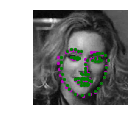

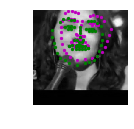

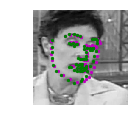

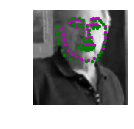

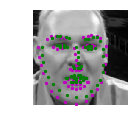

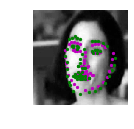

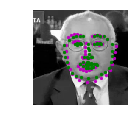

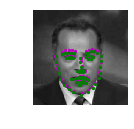

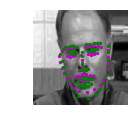

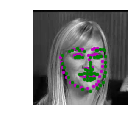

3.77999186163257 1.549200046742515


In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
from statistics import mean 
visualize_output(test_images, test_outputs, gt_pts)
x_axis = []
y_axis = []
for i in range(68):
    a= np.square(np.subtract(test_outputs[0][i].cpu().detach().numpy(), gt_pts[0][i].numpy()))
    x_axis.append(a[0])
    y_axis.append(a[1])
print(mean(x_axis)*1000, mean(y_axis)*1000)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [17]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: ***Loss Function: Mean Square Error,*** Since we are working on regression, Mean Square Error is the great choice to detect the difference between the two pixels.

   ***Optimizer: Adam,*** as it converges very fast and efficiently, it salso supports the problem of vanishing and exploding gradient and momentum helps to find the global minima.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with naimish-net(paper which was mentioned in the project) which has 4 convolutional layers along with 3 fullyconnected layers and used elu as activatiion function, I discovered that 4 layers were not performing good as the number of facial points were different, so I added one more convolutional layer which helped model to find the pattern in more efficient way. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: ***Number of Epochs:*** It is decided on the basis of average loss, as it starts converge, training of model gets stopped for further training.

***batch_size: *** size where the loss is minimum at the particular learning rate of the optimizer and number of epochs

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/ma/sparsh/scripts/P1_Facial_Keypoints/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


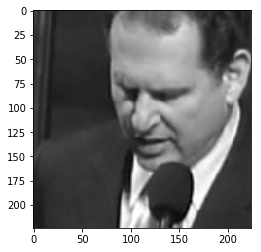

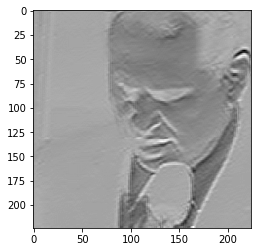

In [38]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
dataiter = iter(test_loader)
dataset =  dataiter.next()
images, labels = dataset['image'], dataset['keypoints']
images = images.numpy()
# select an image by index
idx = 3
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(12, 4))
columns = 5*2
rows = 2
c = cv2.filter2D(img, -1, w[0][0])
plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It detects horizontal lines and darkens all the brightest pixels and lightens all the dark pixels, we can see the suit color changes towards bright. It tries to detect the light pixels as face belongs to light pixels.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!